# Gun Violence : What's the Missing Link?

## Friday Practical 5 Group B

>Vanessa Angelica |   **44284454**   
>Thomas Yap | **44930534**   
>Hamza Ahmed |   **45463077**   

# Introduction 

Gun Violence has been rampant within the United States (US) over the past few years and there has been multiple schools of thought behind what has exactly caaused this. For example, Republicans have claimed it to Video Games and how it is negatively affecting children. Previously, the Black Lives Matter movement was created due to Gun Violence against African Americans in the US and this piqued our interest regarding to the plethora of factors being linked to Gun Violence. Thus, 
**The question we are considering throughout this report is: " Could there be any other factors attributed to gun violence?"**


## Baseline Performance

We are using this [Gun Violence Analysis](https://github.com/Cng000/Gun-violence-analysis) as a baseline project that is done on the contributions of certain factors to the number of occurences of Gun Violence within the United States. This report looked at how **total population**, **unemployment**, **education**, and the **level of guns supplied** through the NRA spending to predict what is the level of gun occurences. 

From their results, they have concluded the correlation results to be:

population_estimate_2017: **0.854610**

unemployment_rate_of_2017: **0.447909**

percentage_of_less_than_hs: **0.527974**

nra_direct_support:  **0.609502**

We have also researched into other possible factors linking to the number of gun occurences such as weather as conducted in this [report](https://www.sciencedirect.com/science/article/pii/S0095069613001289). This has led us to consider if the weather conditions could affect gun violence.

# Hypothesis

**MAIN HYPOTHESIS :**

**There is an underlying factor that contributes to gun violence not yet discovered.**

From the main hypothesis, we can break it into smaller components.

**SUB-HYPOTHESIS :**

1) There is an underlying factor that contributes to gun violence in the US

2) The severity of gun violence in the US can be predicted based on variables in the dataset

# Our Approach

To answer our hypothesis, we are using the following approach.

1) Data preparation: load and transform the data as preparation for the analysis

2) Answering sub-hypothesis 1 through exploration and visualtisation of the dataset

3) Answering sub-hypothesis 2 through creating models in order to try to predict severity levels

4) Provide answers/explanations to our results as well as validate our baseline performance

5) Conclusion

# Packages

In [1]:
import seaborn as sns
import pandas as pd 
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats
from scipy.stats import pearsonr
from numpy.polynomial.polynomial import polyfit
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from matplotlib.pyplot import imread

#To remove the red box errors just to make the notebook look neater
import warnings
warnings.filterwarnings("ignore")

# 1. Dataset and Dataframe Manipulation

## 1.1. Gun Violence Data

The Gun Violence Data was extracted from [gun violence archive](http://www.gunviolencearchive.org/) and contains more than 260,000 reports of gun violence since 2013 to 2018 and this will be our main dataset that we will conduct our exploration and analysis on.

The dataset contains data on the individual occurences of gun violence and we will be using relevant data such as the state it occured in, the number of people injured/killed, the number of guns involved, the age of the suspect etc. The full list of variables used will be shown below.

**Data Cleaning and Manipulation**

In [2]:
# Import the Gun Violence Data into Python 
gun_violence_data_raw = pd.read_csv("data/gun-violence-data_01-2013_03-2018.csv")

In [3]:
# Dropped unneccesary columns
gun_violence_data_clean = gun_violence_data_raw.drop(['address', 'gun_stolen', 'gun_type',
                                                      'participant_age_group', 'state_house_district', 'state_senate_district',
                                                      'participant_status', 'congressional_district',
                                                      'participant_relationship', 'incident_url', 'city_or_county',
                                                      'incident_url_fields_missing', 'source_url', 
                                                      'notes', 'incident_characteristics', 'location_description', 
                                                      'sources', 'participant_name'], axis=1)
gun_violence_data_clean['date'] =  pd.to_datetime(gun_violence_data_clean['date'], format='%Y-%m-%d')
gun_violence_data_clean['year'] = pd.DatetimeIndex(gun_violence_data_clean['date']).year
gun_violence_data_clean['month'] = pd.DatetimeIndex(gun_violence_data_clean['date']).month

**Aggregating yearly data**

In [4]:
# Aggregated data into years for the number of casualties and counts
gun_violence_pyr = gun_violence_data_clean.drop(['latitude', 'longitude', 'month'], axis = 1)
gun_violence_pyr = gun_violence_pyr.groupby(['year']).sum()

In [5]:
# Final yearly dataset
gun_violence_pyr 

,incident_id,n_killed,n_injured,n_guns_involved
year,,,,
2013,143036120,317,979,121.0
2014,8991412704,12557,23002,7927.0
2015,20388301930,13484,26967,36849.0
2016,35918098535,15066,30580,53821.0
2017,54111867885,15511,30703,76189.0
2018,14506860969,3533,6171,17545.0


**Extracting suspect characteristics**

In [6]:
# Function to get suspect's characteristic (age, gender)
def get_sus(par_type, par_char):
    if pd.isnull(par_type):
        return -1
    else:
        x = par_type[par_type.find('Subject-Suspect')-3]
        
    if pd.isnull(par_char):
        return -1
    
    idx = x+"::"
    if par_char.find(idx) == -1:
        return -1
    else:
        sta = par_char.find(idx)+3
        if par_char.find('||', sta, len(par_char)) == -1:
            end = len(par_char)
        else:
            end = par_char.find('||', par_char.find(idx), len(par_char))
        
        return par_char[sta:end]

In [7]:
# Function to transform gender into a binary value
def get_gender(x):
    if x == "Female":
        return 1
    elif x == "Male":
        return 0
    else:
        return -1

In [8]:
# Applying functions above to obtain suspect age and gender
gun_violence_data_clean['suspect_age'] = gun_violence_data_clean.apply(lambda x: get_sus(x.participant_type, x.participant_age), axis=1)
gun_violence_data_clean['suspect_gender'] = gun_violence_data_clean.apply(lambda x: get_sus(x.participant_type, x.participant_gender), axis=1)
gun_violence_data_clean['suspect_gender'] = gun_violence_data_clean.apply(lambda x: get_gender(x.suspect_gender), axis=1)

In [9]:
# Changing data to type int
gun_violence_data_clean['suspect_age'] = gun_violence_data_clean['suspect_age'].astype(int)
gun_violence_data_clean['suspect_gender'] = gun_violence_data_clean['suspect_gender'].astype(int)

In [10]:
# Drop columns no longer used
gun_violence_data_clean = gun_violence_data_clean.drop(['participant_type', 'participant_age', 'participant_gender'], axis=1)

In [11]:
# Get column for day of week
gun_violence_data_clean['day_of_week'] = gun_violence_data_clean['date'].dt.dayofweek

In [12]:
# Drop all the missing values denoted with "-1" and NaN
gun_violence_data_clean = gun_violence_data_clean[gun_violence_data_clean['suspect_age']!=-1]
gun_violence_data_clean = gun_violence_data_clean[gun_violence_data_clean['suspect_gender']!=-1]
gun_violence_data_clean = gun_violence_data_clean.dropna()

In [13]:
# Final and Cleaned Dataset
gun_violence_data_clean.head()

,incident_id,date,state,n_killed,n_injured,latitude,longitude,n_guns_involved,year,month,suspect_age,suspect_gender,day_of_week
2,478855,2013-01-01,Ohio,1,3,41.4455,-82.1377,2.0,2013,1,25,0,1
4,478959,2013-01-07,North Carolina,2,2,36.1140,-79.9569,2.0,2013,1,47,1,0
6,479363,2013-01-19,New Mexico,5,0,34.9791,-106.7160,2.0,2013,1,15,0,5
12,479561,2013-01-26,Louisiana,2,3,29.8816,-91.5251,1.0,2013,1,48,0,5
15,479573,2013-02-02,Tennessee,0,5,35.0803,-89.8871,1.0,2013,2,24,1,5


In [14]:
# Final and Cleaned Dataset Shape
gun_violence_data_clean.shape

(54948, 13)

## 1.2. Weather Data

The Weather Data we have is from Kaggle and contains hourly weather data in the United States and some other countries. The dataset was aquired using [Weather API](https://openweathermap.org/api) on the [OpenWeatherMap website](https://openweathermap.org/).

This dataset contains multiple csv files containing meteorological data such as Temperature, Humidity, Pressure and Wind Data.

In [15]:
# Import Met Data into Python
temp_raw = pd.read_csv("data/temperature.csv")
humid_raw = pd.read_csv("data/humidity.csv")
pressure_raw = pd.read_csv("data/pressure.csv")
wind_raw = pd.read_csv("data/wind_speed.csv")

In [16]:
# Function to transform hourly data by city to daily data by state.
# We do this by taking the average each day and the average for cities within the same state
def weather_cleaning(x):
    x = x.drop(['Vancouver', 'Toronto', 'Beersheba', 'Tel Aviv District','Eilat', 'Haifa', 'Nahariyya', 
                'Jerusalem', 'Montreal'], axis = 1)
    x = x.dropna()
    
    x['datetime'] = pd.to_datetime(x['datetime'], format='%Y-%m-%d %H:%M:%S')
    x['date'] = pd.DatetimeIndex(x['datetime']).date
    x = x.groupby('date').mean()
    
    California = x[['San Francisco', 'Los Angeles', 'San Diego', 'Las Vegas']]
    Texas = x[['San Antonio', 'Dallas', 'Houston']]
    Missouri = x[['Kansas City','Saint Louis']]
    Florida = x[['Jacksonville', 'Miami']]
    Pennsylvania = x[['Pittsburgh', 'Philadelphia']]
    
    California['mean'] = California.mean(axis = 1)
    Texas['mean'] = Texas.mean(axis = 1)
    Missouri['mean'] = Missouri.mean(axis = 1)
    Florida['mean'] = Florida.mean(axis = 1)
    Pennsylvania['mean'] = Pennsylvania.mean(axis = 1)
    
    x = x.drop(['San Francisco', 'Los Angeles', 'San Diego', 'Las Vegas', 'San Antonio', 'Dallas', 'Houston',
                'Kansas City','Saint Louis', 'Jacksonville', 'Miami', 'Pittsburgh', 'Philadelphia'], axis = 1)
    
    colnames = ['Oregon', 'Washington', 'Arizona', 'New Mexico', 'Colorado', 'Minnesota', 'Illinois', 
                'Tennessee', 'Indiana', 'Georgia', 'Michigan', 'North Carolina', 'New York',
                'Massachusetts']
    
    x.columns = colnames
    
    x['California'] = California['mean']
    x['Texas'] = Texas['mean']
    x['Missouri'] = Missouri['mean']
    x['Florida'] = Florida['mean']
    x['Pennsylvania'] = Pennsylvania['mean']
    
    x.index = pd.to_datetime(x.index, format='%Y-%m-%d')

    return x

In [17]:
# Cleaning weather data according to the function above
temp = weather_cleaning(temp_raw)
humid = weather_cleaning(humid_raw)
pressure = weather_cleaning(pressure_raw)
wind = weather_cleaning(wind_raw)

In [18]:
# Final and Cleaned Dataset example for Temprature
temp.head()

,Oregon,Washington,Arizona,New Mexico,Colorado,Minnesota,Illinois,Tennessee,Indiana,Georgia,Michigan,North Carolina,New York,Massachusetts,California,Texas,Missouri,Florida,Pennsylvania
date,,,,,,,,,,,,,,,,,,,
2012-10-01,282.118197,281.767262,296.701739,285.476208,284.577328,287.127799,284.552669,287.556459,284.100689,294.093604,284.492344,288.651832,288.569420,287.371091,291.548887,289.309557,288.201803,299.229395,283.662832
2012-10-02,286.137728,285.156888,301.211968,289.771821,286.228571,289.347277,287.713511,289.448165,286.118744,294.730505,287.584232,288.861542,290.892389,289.013090,295.347153,292.722668,290.163362,300.530524,287.008696
2012-10-03,289.599792,287.673958,302.867083,291.205417,288.747500,286.642083,289.127917,289.206667,286.454583,293.592292,288.679583,295.560625,290.065625,289.020833,298.627083,294.124097,290.129479,299.495104,290.385833
2012-10-04,286.482500,284.391667,302.232917,293.096250,291.593333,288.395833,290.032500,289.512083,288.807083,291.023750,290.152083,294.755833,291.987083,290.043750,297.396458,293.889444,290.595000,299.466458,293.426250
2012-10-05,288.286042,284.756250,301.811250,292.829167,280.709375,285.186875,291.207500,291.901250,290.743750,292.156458,291.401042,294.180000,294.043542,289.517292,294.526667,297.188750,290.896667,299.851562,292.761458


In [19]:
# Final and Cleaned Dataset shape for Temprature
temp.shape

(1854, 19)

## 1.3. Demographic Data
The Demographic Data we have is from Kaggle and contains demographic data in the United States by state. The dataset was aquired from the US Census Bureau and contains CSV files for 2015 and 2017.

In [20]:
#Import Demographic Data into Python
demographic_data_2015_raw = pd.read_csv("data/acs2015_county_data.csv")
demographic_data_2017_raw = pd.read_csv("data/acs2017_county_data.csv")

In [21]:
#dropped columns to obtain population demographic distribution
demographic_data_2015_clean = demographic_data_2015_raw.drop(['CensusId', 'County', 'ChildPoverty', 'Professional', 
                                                              'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'IncomePerCapErr', 'IncomeErr', 'Citizen', 'IncomePerCap'], axis=1)

demographic_data_2017_clean = demographic_data_2017_raw.drop(['CountyId', 'County', 'ChildPoverty', 'Professional', 
                                                              'Service', 'Office', 'Construction', 'Production', 
                                                              'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
                                                              'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork',
                                                              'PublicWork', 'SelfEmployed', 'FamilyWork', 
                                                              'IncomePerCapErr', 'IncomeErr', 'VotingAgeCitizen', 
                                                              'IncomePerCap'], axis=1)

In [22]:
# Aggregating data by state by first transforming the percentages to absolute values
for x in range(4, 10):
    demographic_data_2015_clean.iloc[:,x] *= demographic_data_2015_clean['TotalPop']/100

for x in range(11, 13):
    demographic_data_2015_clean.iloc[:,x] *= demographic_data_2015_clean['TotalPop']/100

demographic_data_2015_clean = demographic_data_2015_clean.groupby(['State']).sum()
demographic_data_2015_clean = demographic_data_2015_clean.drop(['Puerto Rico', 'District of Columbia'], axis=0)

for x in range(4, 10):
    demographic_data_2017_clean.iloc[:,x] *= demographic_data_2017_clean['TotalPop']/100

for x in range(11, 13):
    demographic_data_2017_clean.iloc[:,x] *= demographic_data_2017_clean['TotalPop']/100

demographic_data_2017_clean = demographic_data_2017_clean.groupby(['State']).sum()
demographic_data_2017_clean = demographic_data_2017_clean.drop(['Puerto Rico', 'District of Columbia'], axis=0)

In [23]:
# Final and Cleaned Demographic Dataset (2017)
demographic_data_2017_clean.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Income,Poverty,Unemployment
State,,,,,,,,,,,,
Alabama,4850771,2350806,2499965,1.984226e+05,3.197914e+06,1280355.937,22705.235,61684.727,930.376,2698184,871882.106,366334.997
Alaska,738565,386319,352246,5.031154e+04,4.545412e+05,22345.074,101645.683,44769.379,8654.760,1926338,75158.036,59135.992
Arizona,6809946,3385055,3424891,2.103452e+06,3.785523e+06,277142.692,264787.551,208383.309,11884.403,687250,1154440.764,490956.865
Arkansas,2977944,1461651,1516293,2.134141e+05,2.174122e+06,457346.223,17057.791,42058.343,6778.196,2926881,541339.268,189431.953
California,38982847,19366579,19616268,1.510633e+07,1.477825e+07,2162585.146,138889.095,5430078.213,135170.283,3540712,5893471.436,3028476.697


## 1.4. Socio-economic Data

The data we have imported contains csv files on [Homeslessness](https://ourworldindata.org/homelessness) and [GDP](https://ourworldindata.org/economic-growth) over the years. As we are comparing it with our gun violence dataset which only streches from 2013-2018, we are restricting the analysis to only years 2014-2016 to ensure data quality.

#### Homelessness Data

In [24]:
number_of_homeless_people_by_shelter_status_raw = pd.read_csv("data/number-of-homeless-people-by-shelter-status.csv")

In [25]:
#Added a total number of homeless people
number_of_homeless_people_by_shelter_status_raw['total homeless'] = number_of_homeless_people_by_shelter_status_raw['Sheltered Homeless (Percent)'] + number_of_homeless_people_by_shelter_status_raw['Unsheltered Homeless (Percent)']
number_of_homeless_people_by_shelter_status_clean1 = number_of_homeless_people_by_shelter_status_raw.drop(['Sheltered Homeless (Percent)','Unsheltered Homeless (Percent)'], axis=1)
number_of_homeless_people_by_shelter_status_clean2 = number_of_homeless_people_by_shelter_status_clean1.iloc[6:10]
number_of_homeless_people_by_shelter_status_clean2
df_number_of_homeless_people_by_shelter_status_clean2 = pd.DataFrame(number_of_homeless_people_by_shelter_status_clean2)

#changing df_homless coloumn name 
df_number_of_homeless_people_by_shelter_status_clean2.rename(columns={'Year':'year'}, inplace=True)

#### GDP Data

In [26]:
gdp_per_capita_worldbank_raw = pd.read_csv("data/gdp-per-capita-worldbank.csv")

In [27]:
#Sorting out the GDP dataframe
df_gdp = gdp_per_capita_worldbank_raw.iloc[6127:6130]

#Renaming a coloumn
df_gdp.rename(columns={'GDP per capita (int.-$) (constant 2011 international $)':'GDP per capita', 'Year':'year'}, inplace=True)

#Renaming a coloumn
df_gdp.rename(columns={'GDP per capita (int.-$) (constant 2011 international $)':'GDP per capita', 'Year':'year'}, inplace=True)

#Dropping coloumns
df_gdp_clean = df_gdp.drop(columns=['Entity', 'Code'])

# 2. Data Visualisation / Exploration

According to For Dummies, a correlation coefficient can be interpreted this way:

A positive (uphill) relationship: the variables move together.

Exactly 1 is a perfect relationship
Between 0.70 and 1 is a strong relationship
Between 0.50 and 0.70 is a moderate relationship
Between 0.30 and 0.50 is a weak relationship
A negative (downhill) relationship: the variables move opposite to each other.

Exactly -1 is a perfect relationship
Between -0.70 and -1 is a strong relationship
Between -0.50 and -0.70 is a moderate relationship
Between -0.30 and -0.50 is a weak relationship
A correlation score between -0.30 and +0.30 shows no relationship.

### 2.1. Socio Economic Data

In order to analyse this dataset, we need to first aggregate the number of casualties before correlating them with the different years and performing visualisations.

In [28]:
# Added a "casualty" column
gun_violence_pyr['casualties'] = gun_violence_pyr['n_killed'] + gun_violence_pyr['n_injured']
df_casualty_pyr1 = pd.DataFrame(gun_violence_pyr.casualties)

#Dropping 2013 from the 'casualties' table
df_casualty_pyr = df_casualty_pyr1.drop(df_casualty_pyr1.index[0])

#Added a total number of homeless people
number_of_homeless_people_by_shelter_status_raw['total homeless'] = number_of_homeless_people_by_shelter_status_raw['Sheltered Homeless (Percent)'] + number_of_homeless_people_by_shelter_status_raw['Unsheltered Homeless (Percent)']
number_of_homeless_people_by_shelter_status_clean1 = number_of_homeless_people_by_shelter_status_raw.drop(['Sheltered Homeless (Percent)','Unsheltered Homeless (Percent)'], axis=1)
number_of_homeless_people_by_shelter_status_clean2 = number_of_homeless_people_by_shelter_status_clean1.iloc[6:10]                                                                                                    
df_number_of_homeless_people_by_shelter_status_clean2 = pd.DataFrame(number_of_homeless_people_by_shelter_status_clean2)

#changing df_homless coloumn name 
df_number_of_homeless_people_by_shelter_status_clean2.rename(columns={'Year':'year'}, inplace=True)

#merging casualties & homeless ppl dataset
df_ch = pd.merge(df_number_of_homeless_people_by_shelter_status_clean2, df_casualty_pyr, on='year')

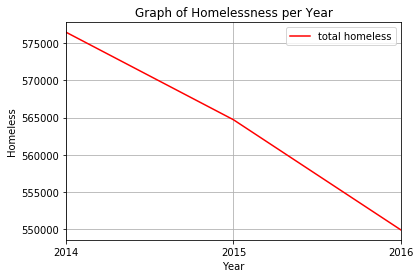

In [29]:
# a line plot showing the trend of total number of homeless people throughout the years
df_ch.plot(kind='line',x='year',y='total homeless',color='red', grid=True)
plt.gca().set_xticks(df_ch["year"].unique())
plt.title("Graph of Homelessness per Year")
plt.xlabel("Year")
plt.ylabel("Homeless")
plt.show()

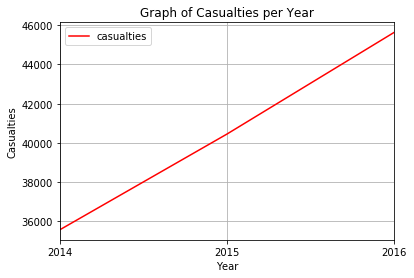

In [30]:
# a line plot showing the trend of total number of casualties throughout the years
df_ch.plot(kind='line',x='year',y='casualties',color='red', grid=True)
plt.gca().set_xticks(df_ch["year"].unique())
plt.title("Graph of Casualties per Year")
plt.xlabel("Year")
plt.ylabel("Casualties")
plt.show()

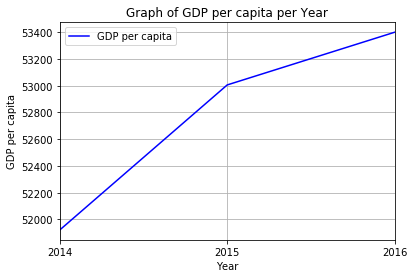

In [31]:
#merging GDP & casualties
df_cg = pd.merge(df_gdp_clean, df_casualty_pyr, on='year')
#final merge
df_fm = pd.merge(df_ch, df_cg, on=['year','casualties'])
# a scatter plot showing the trend of GDP per capita throughout the years
df_cg.plot(kind='line',x='year',y='GDP per capita',color='blue', grid=True)
plt.gca().set_xticks(df_cg["year"].unique())
plt.title("Graph of GDP per capita per Year")
plt.xlabel("Year")
plt.ylabel("GDP per capita")
plt.show()


In [32]:
#Adding coloumn for percentage change
df_fm[['Change of casualites','Change of homeless','change of GDP per capita']]= df_fm.sort_values(['year']).groupby('Entity')[['casualties','total homeless', 'GDP per capita']].pct_change()
df_fm.fillna(0, inplace=True)

Text(0, 0.5, 'Amount of Change')

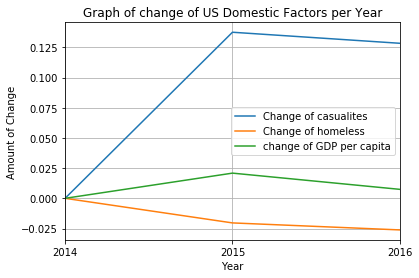

In [33]:
#Comparing change of homeless people, GDP per capita and casualties throughout the years
df_fm.plot(kind='line',x='year',y=['Change of casualites','Change of homeless','change of GDP per capita'],grid=True,)
plt.gca().set_xticks(df_fm["year"].unique())
plt.title("Graph of change of US Domestic Factors per Year")
plt.xlabel("Year")
plt.ylabel("Amount of Change")

The graph above shows the rate at which the amount of **'homeless people', 'casualties'** and **'GDP per capita'** in the United State changed over a 3 year period 2014 to 2016.

Overall, the amount of casualties and GDP per capita increased, whereas the amount of homeless followed a declining trend. 

Looking at the trends overtime, the growth of casualties increased by around **13.8%** from 2014 to 2015 and then slowed to about **12.8%** from 2015 to 2016. 

Similarly, change in the GDP per capita followed an upward trend where it grew by around **2.1%** in 2015 before slowing to **0.7%** from 2015 to 2016. 

On the other hand, the amount of homeless people followed a downward trajectory. Homelessness decreased by about **2.0%** in 2015. Similarly, in 2016 it dropped slightly by about **2.6%**. 

Hence, we can conclude that since there is a difference in movements of the rate of change, there is not enough evidence prove a correlation between GDP and Homelessness to Casualties.

### 2.2. Demographic Data

We are looking at the number of incident counts for 2015 and 2017.

In [34]:
df_gun_violence_2015_counts = gun_violence_data_clean.loc[gun_violence_data_clean.year == 2015]['state'].value_counts().reset_index().rename(index=str, columns={'index':'State', 'state':'incident_counts_2015'})
df_gun_violence_2017_counts = gun_violence_data_clean.loc[gun_violence_data_clean.year == 2017]['state'].value_counts().reset_index().rename(index=str, columns={'index':'State', 'state':'incident_counts_2017'})

In [35]:
# Extract the total population of that year per state
df_state_pop = demographic_data_2015_clean[['TotalPop']]
df_state_pop = demographic_data_2017_clean[['TotalPop']]

In [36]:
# Df combining the 2 series of data
df_incidents_population_2015 = df_state_pop.merge(df_gun_violence_2015_counts, how='inner', on = 'State')
df_incidents_population_2017 = df_state_pop.merge(df_gun_violence_2017_counts, how='inner', on = 'State')

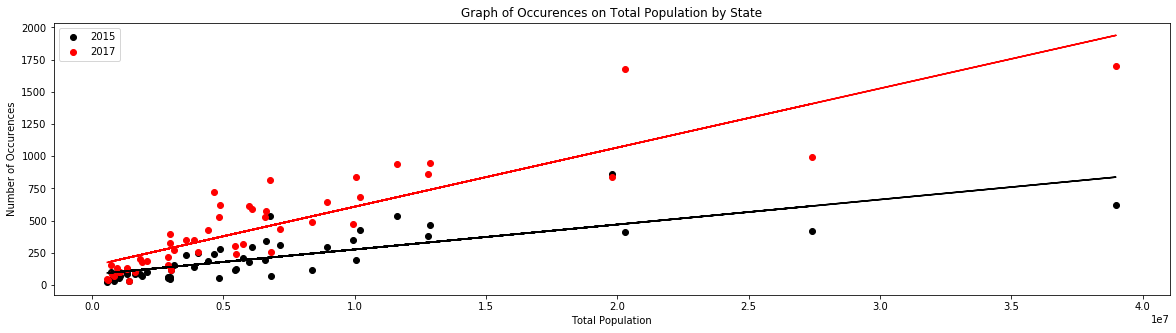

In [37]:
#Graph of incidents on population
plt.figure(figsize = (20,5))
plt.scatter(df_incidents_population_2015.TotalPop,df_incidents_population_2015.incident_counts_2015, color = 'black', label = "2015")
plt.scatter(df_incidents_population_2017.TotalPop,df_incidents_population_2017.incident_counts_2017, color = 'red', label = "2017")
plt.xlabel("Total Population")
plt.ylabel("Number of Occurences")
plt.title("Graph of Occurences on Total Population by State")
b, m = polyfit(df_incidents_population_2015.TotalPop, df_incidents_population_2015.incident_counts_2015, 1)
a, n = polyfit(df_incidents_population_2017.TotalPop, df_incidents_population_2017.incident_counts_2017, 1)
plt.plot(df_incidents_population_2015.TotalPop, b + m * df_incidents_population_2015.TotalPop, '-', color = 'black')
plt.plot(df_incidents_population_2017.TotalPop, a + n * df_incidents_population_2017.TotalPop, '-', color = 'red')
plt.legend()
plt.savefig('Graph of Occurences on Total Population by State.png')

In [38]:
print("Pearson's correlation values for 2015:")
print(df_incidents_population_2015.corr(method='pearson'))
print()
print("Pearson's correlation values for 2017:")
print(df_incidents_population_2017.corr(method='pearson'))

Pearson's correlation values for 2015:
                      TotalPop  incident_counts_2015
TotalPop              1.000000              0.772892
incident_counts_2015  0.772892              1.000000

Pearson's correlation values for 2017:
                      TotalPop  incident_counts_2017
TotalPop              1.000000              0.879276
incident_counts_2017  0.879276              1.000000


Compared to the initial study done, we have a slightly higher pearson correlation score between Total Population and Number of occurences at 2017 to 0.853839. This is due to the difference in the datasets used. We have used the yearly demographic data from Kaggle that is updated from the US Census Bureau whereas the previous study was using estimate data.

These results validate the previous study done as the trends presented are similar to their overarching hypothesis as well.

We have also seen that there is an increase in correlation between 2015 and 2017, showing that there has been more gun inicidents.

### 2.3. Demographic Distribution by Race

We are looking at different race: Hispanic, Black, White, Pacific, Native and Asian, in order to conduct our analysis. We are aware that there are other races within those states but we are considering these major races only as they are are larger demographics of people. We will compare this to the occurences of gun violence in order to see if within the states, is there an increase in the level of gun occurences based on the increased number of that particular race.

In [39]:
df_state_race_2015 = demographic_data_2015_clean[['TotalPop','Hispanic','Black','White','Pacific','Native','Asian']]

#Create empirical data for races
for x in range(1, 7):
    df_state_race_2015.iloc[:,x] /= df_state_race_2015['TotalPop']
    
df_state_race_2017 = demographic_data_2017_clean[['TotalPop','Hispanic','Black','White','Pacific','Native','Asian']]

#Create empirical data for races
for x in range(1, 7):
    df_state_race_2017.iloc[:,x] /= df_state_race_2017['TotalPop']

In [40]:
#Merge df and create empirical incidents to make comparisons fair
df_incidents_race_2015 = df_state_race_2015.merge(df_gun_violence_2015_counts, how='inner', on = 'State')
df_incidents_race_2015['incidents per capita']=df_incidents_race_2015.incident_counts_2015/df_incidents_race_2015.TotalPop
df_incidents_race_2017 = df_state_race_2017.merge(df_gun_violence_2017_counts, how='inner', on = 'State')
df_incidents_race_2017['incidents per capita']=df_incidents_race_2017.incident_counts_2017/df_incidents_race_2017.TotalPop

In [41]:
#Find outliers in data using Z-scores
for race in ['Hispanic','Black','White','Pacific','Native','Asian']:
    z1 = np.abs(stats.zscore(df_incidents_race_2015[race]))
    df_incidents_race_2015_clean = df_incidents_race_2015[(z1 < 3)]
    z2 = np.abs(stats.zscore(df_incidents_race_2017[race]))
    df_incidents_race_2017_clean = df_incidents_race_2017[(z1 < 3)]

Next, we are going to visualise the relationships between the distribution per race and the incidents per capita

#### Hispanic

The correlation between the number of Hispanic people and number of gun violences in 2015 is :  -0.2761962421799303
The correlation between the number of Hispanic people and number of gun violences in 2017 is :  -0.40645069384679966


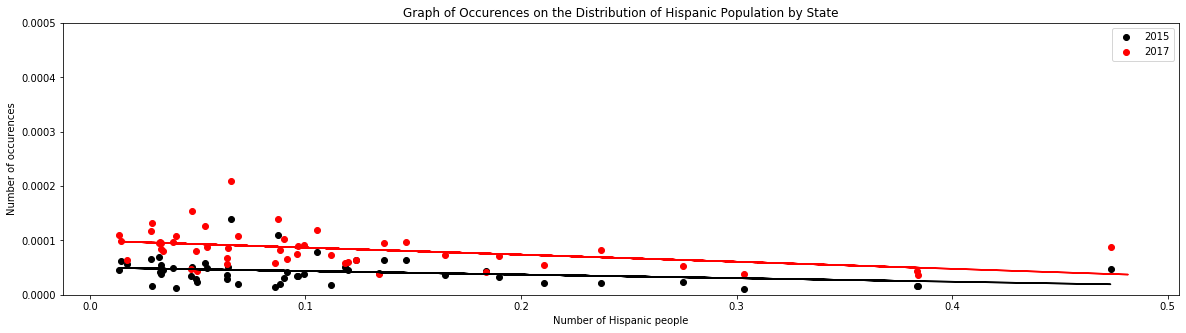

In [42]:
plt.figure(figsize = (20,5))
plt.scatter(df_incidents_race_2015_clean.Hispanic,df_incidents_race_2015_clean['incidents per capita'], color = 'black', label = "2015")
plt.scatter(df_incidents_race_2015_clean.Hispanic,df_incidents_race_2017_clean['incidents per capita'], color = 'red', label = "2017")
plt.ylim(0,0.0005)
plt.title("Graph of Occurences on the Distribution of Hispanic Population by State")
plt.ylabel("Number of occurences")
plt.xlabel("Number of Hispanic people")
corr_h1, p_h = stats.pearsonr(df_incidents_race_2015_clean.Hispanic,df_incidents_race_2015_clean['incidents per capita'])
corr_h2, p_h = stats.pearsonr(df_incidents_race_2017_clean.Hispanic,df_incidents_race_2017_clean['incidents per capita'])
print('The correlation between the number of Hispanic people and number of gun violences in 2015 is : ' , corr_h1)
print('The correlation between the number of Hispanic people and number of gun violences in 2017 is : ' , corr_h2)


b, m = polyfit(df_incidents_race_2015_clean.Hispanic, df_incidents_race_2015_clean['incidents per capita'], 1)
plt.plot(df_incidents_race_2015_clean.Hispanic, b + m * df_incidents_race_2015_clean.Hispanic, '-', color = 'black')

b, m = polyfit(df_incidents_race_2017_clean.Hispanic, df_incidents_race_2017_clean['incidents per capita'], 1)
plt.plot(df_incidents_race_2017_clean.Hispanic, b + m * df_incidents_race_2017_clean.Hispanic, '-', color = 'red')
plt.legend()
plt.savefig('Graph of Occurences on the Distribution of Hispanic Population by State.png')

#### Black

The correlation between the number of Black people and number of gun violences in 2015 is :  -0.22123098869099955
The correlation between the number of Black people and number of gun violences in 2017 is :  0.278882018159486


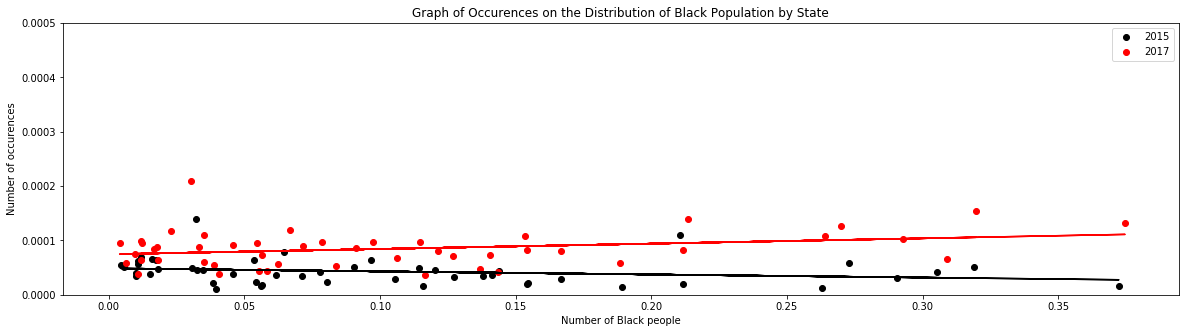

In [43]:
plt.figure(figsize = (20,5))
plt.scatter(df_incidents_race_2015_clean.Black,df_incidents_race_2015_clean['incidents per capita'], color = 'black', label = "2015")
plt.scatter(df_incidents_race_2017_clean.Black,df_incidents_race_2017_clean['incidents per capita'], color = 'red', label = "2017")
plt.ylim(0,0.0005)
plt.ylabel("Number of occurences")
plt.xlabel("Number of Black people")
plt.title("Graph of Occurences on the Distribution of Black Population by State")
corr_b1, p_b = stats.pearsonr(df_incidents_race_2015_clean.Black,df_incidents_race_2015_clean['incidents per capita'])
corr_b2, p_b = stats.pearsonr(df_incidents_race_2017_clean.Black,df_incidents_race_2017_clean['incidents per capita'])
print('The correlation between the number of Black people and number of gun violences in 2015 is : ' , corr_b1)
print('The correlation between the number of Black people and number of gun violences in 2017 is : ' , corr_b2)

b, m = polyfit(df_incidents_race_2015_clean.Black, df_incidents_race_2015_clean['incidents per capita'], 1)
plt.plot(df_incidents_race_2015_clean.Black, b + m * df_incidents_race_2015_clean.Black, '-', color = 'black')

b, m = polyfit(df_incidents_race_2017_clean.Black, df_incidents_race_2017_clean['incidents per capita'], 1)
plt.plot(df_incidents_race_2017_clean.Black, b + m * df_incidents_race_2017_clean.Black, '-', color = 'red')
plt.legend()
plt.savefig("Graph of Occurences on the Distribution of Black Population by State")

#### White

The correlation between the number of White people and number of gun violences in 2015 is :  0.24841703848521177
The correlation between the number of White people and number of gun violences in 2017 is :  0.06428227215601741


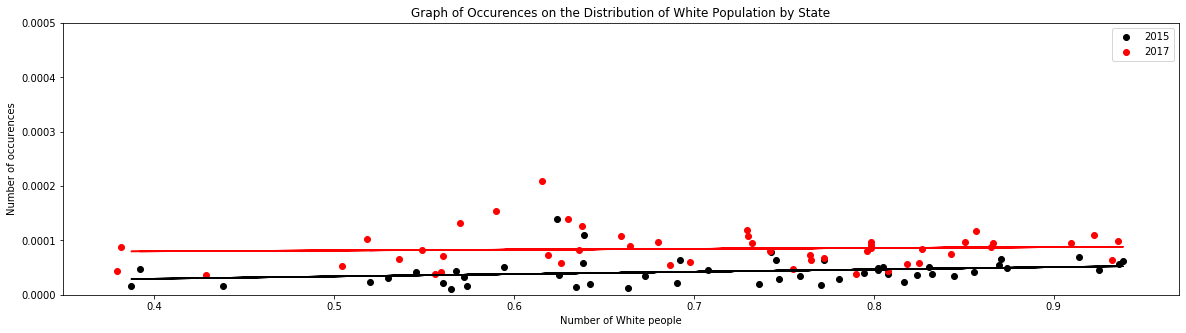

In [44]:
plt.figure(figsize = (20,5))
plt.scatter(df_incidents_race_2015_clean.White,df_incidents_race_2015_clean['incidents per capita'], color = 'black', label = "2015")
plt.scatter(df_incidents_race_2017_clean.White,df_incidents_race_2017_clean['incidents per capita'], color = 'red', label = "2017")
plt.ylim(0,0.0005)
plt.ylabel("Number of occurences")
plt.xlabel("Number of White people")
plt.title("Graph of Occurences on the Distribution of White Population by State")
corr_w1, p_w = stats.pearsonr(df_incidents_race_2015_clean.White,df_incidents_race_2015_clean['incidents per capita'])
corr_w2, p_w = stats.pearsonr(df_incidents_race_2017_clean.White,df_incidents_race_2017_clean['incidents per capita'])
print('The correlation between the number of White people and number of gun violences in 2015 is : ' , corr_w1)
print('The correlation between the number of White people and number of gun violences in 2017 is : ' , corr_w2)

b, m = polyfit(df_incidents_race_2015_clean.White, df_incidents_race_2015_clean['incidents per capita'], 1)
plt.plot(df_incidents_race_2015_clean.White, b + m * df_incidents_race_2015_clean.White, '-', color = 'black')

b, m = polyfit(df_incidents_race_2017_clean.White, df_incidents_race_2017_clean['incidents per capita'], 1)
plt.plot(df_incidents_race_2015_clean.White, b + m * df_incidents_race_2017_clean.White, '-', color = 'red')
plt.legend()
plt.savefig("Graph of Occurences on the Distribution of White Population by State")

#### Pacific

The correlation between the number of Pacific people and number of gun violences in 2015 is :  0.2954320940383083
The correlation between the number of Pacific people and number of gun violences in 2017 is:  0.11077575558976974


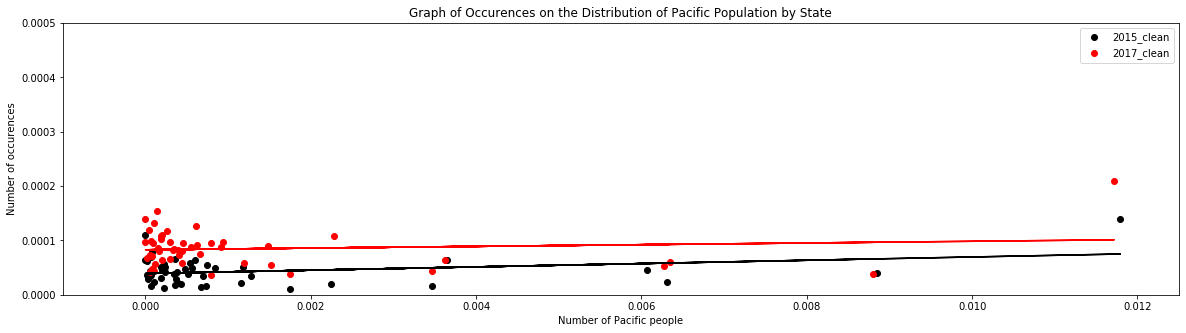

In [45]:
plt.figure(figsize = (20,5))
plt.scatter(df_incidents_race_2015_clean.Pacific,df_incidents_race_2015_clean['incidents per capita'], color = 'black', label = "2015_clean")
plt.scatter(df_incidents_race_2017_clean.Pacific,df_incidents_race_2017_clean['incidents per capita'], color = 'red', label = "2017_clean")
plt.ylim(0,0.0005)
plt.xlim(-0.001, 0.0125)
plt.ylabel("Number of occurences")
plt.xlabel("Number of Pacific people")
plt.title("Graph of Occurences on the Distribution of Pacific Population by State")
corr_p1, p_p = stats.pearsonr(df_incidents_race_2015_clean.Pacific,df_incidents_race_2015_clean['incidents per capita'])
corr_p2, p_p = stats.pearsonr(df_incidents_race_2017_clean.Pacific,df_incidents_race_2017_clean['incidents per capita'])
print('The correlation between the number of Pacific people and number of gun violences in 2015 is : ' , corr_p1)
print('The correlation between the number of Pacific people and number of gun violences in 2017 is: ' , corr_p2)

b, m = polyfit(df_incidents_race_2015_clean.Pacific, df_incidents_race_2015_clean['incidents per capita'], 1)
plt.plot(df_incidents_race_2015_clean.Pacific, b + m * df_incidents_race_2015_clean.Pacific, '-', color = 'black')
b, m = polyfit(df_incidents_race_2017_clean.Pacific, df_incidents_race_2017_clean['incidents per capita'], 1)
plt.plot(df_incidents_race_2017_clean.Pacific, b + m * df_incidents_race_2017_clean.Pacific, '-', color = 'red')
plt.legend()
plt.savefig("Graph of Occurences on the Distribution of Pacific Population by State")

#### Native

The correlation between the number of Native people and number of gun violences in 2015 is :  0.3814235791863217
The correlation between the number of Native people and number of gun violences in 2017 is :  0.3764099413039188


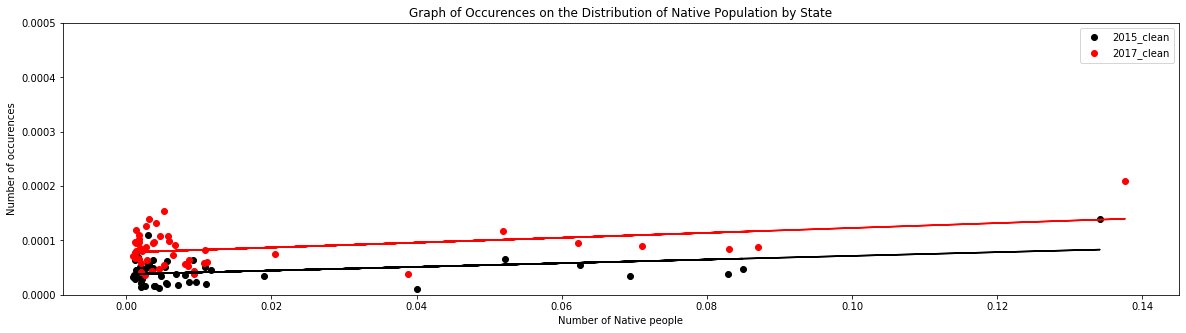

In [46]:
plt.figure(figsize = (20,5))
plt.scatter(df_incidents_race_2015_clean.Native,df_incidents_race_2015_clean['incidents per capita'], color = 'black', label = "2015_clean")
plt.scatter(df_incidents_race_2017_clean.Native,df_incidents_race_2017_clean['incidents per capita'], color = 'red', label = "2017_clean")
plt.ylim(0,0.0005)
plt.ylabel("Number of occurences")
plt.xlabel("Number of Native people")
plt.title("Graph of Occurences on the Distribution of Native Population by State")
corr_n1, p_p = stats.pearsonr(df_incidents_race_2015_clean.Native,df_incidents_race_2015_clean['incidents per capita'])
corr_n2, p_p = stats.pearsonr(df_incidents_race_2017_clean.Native,df_incidents_race_2017_clean['incidents per capita'])
print('The correlation between the number of Native people and number of gun violences in 2015 is : ' , corr_n1)
print('The correlation between the number of Native people and number of gun violences in 2017 is : ' , corr_n2)

b, m = polyfit(df_incidents_race_2015_clean.Native, df_incidents_race_2015_clean['incidents per capita'], 1)
plt.plot(df_incidents_race_2015_clean.Native, b + m * df_incidents_race_2015_clean.Native, '-', color = 'black')
b, m = polyfit(df_incidents_race_2017_clean.Native, df_incidents_race_2017_clean['incidents per capita'], 1)
plt.plot(df_incidents_race_2017_clean.Native, b + m * df_incidents_race_2017_clean.Native, '-', color = 'red')
plt.legend()
plt.savefig("Graph of Occurences on the Distribution of Native Population by State")

#### Asian

The correlation between the number of Asian people and number of gun violences in 2015 is :  -0.04278349998948267
The correlation between the number of Asian people and number of gun violences in 2017 is :  -0.2589371736375274


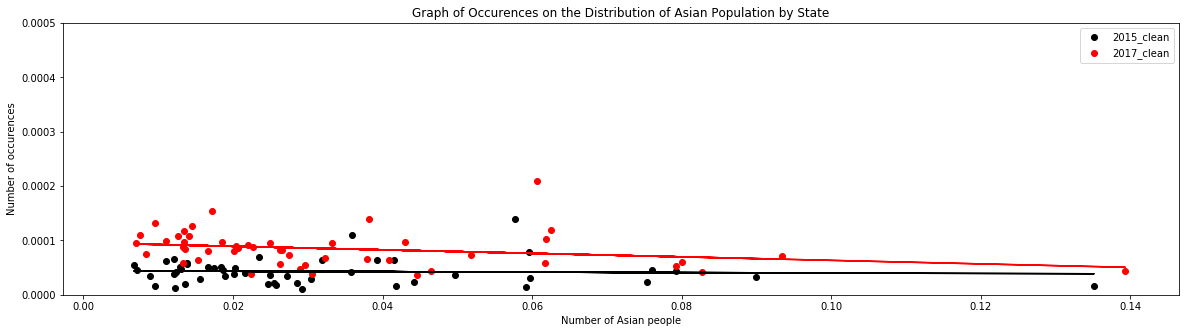

In [47]:
plt.figure(figsize = (20,5))
plt.scatter(df_incidents_race_2015_clean.Asian,df_incidents_race_2015_clean['incidents per capita'], color = 'black', label = "2015_clean")
plt.scatter(df_incidents_race_2017_clean.Asian,df_incidents_race_2017_clean['incidents per capita'], color = 'red', label = "2017_clean")
plt.ylim(0,0.0005)
plt.ylabel("Number of occurences")
plt.xlabel("Number of Asian people")
plt.title("Graph of Occurences on the Distribution of Asian Population by State")
corr_a1, p_p = stats.pearsonr(df_incidents_race_2015_clean.Asian,df_incidents_race_2015_clean['incidents per capita'])
corr_a2, p_p = stats.pearsonr(df_incidents_race_2017_clean.Asian,df_incidents_race_2017_clean['incidents per capita'])
print('The correlation between the number of Asian people and number of gun violences in 2015 is : ' , corr_a1)
print('The correlation between the number of Asian people and number of gun violences in 2017 is : ' , corr_a2)

b, m = polyfit(df_incidents_race_2015_clean.Asian, df_incidents_race_2015_clean['incidents per capita'], 1)
plt.plot(df_incidents_race_2015_clean.Asian, b + m * df_incidents_race_2015_clean.Asian, '-', color = 'black')
b, m = polyfit(df_incidents_race_2017_clean.Asian, df_incidents_race_2017_clean['incidents per capita'], 1)
plt.plot(df_incidents_race_2017_clean.Asian, b + m * df_incidents_race_2017_clean.Asian, '-', color = 'red')
plt.legend()
plt.savefig("Graph of Occurences on the Distribution of Asian Population by State")

From the analysis above, there is no definite link between the percentage distribution of race to the level of incidents in the state. This is due to gun violence being a complex and dynamic variable that race alone can not predict. Let's look at the top 10 most "dangerous" states' race distribution.

In [48]:
# Select only top 10 based on incidents
df_incidents_race_2015_top10 = df_incidents_race_2015_clean.sort_values('incidents per capita', ascending = False).head(10)
# Correction for races outside those listed to make distribution of population equal to 100%
df_incidents_race_2015_top10['Other'] = 1 - df_incidents_race_2015_top10.Hispanic - df_incidents_race_2015_top10.Black - df_incidents_race_2015_top10.White - df_incidents_race_2015_top10.Pacific - df_incidents_race_2015_top10.Native - df_incidents_race_2015_top10.Asian
df_incidents_race_2015_top10

,State,TotalPop,Hispanic,Black,White,Pacific,Native,Asian,incident_counts_2015,incidents per capita,Other
1,Alaska,733375,0.065276,0.032217,0.623764,0.011793,0.134163,0.057730,102,0.000139,0.075057
7,Delaware,926454,0.087060,0.210573,0.638699,0.000000,0.002956,0.035967,102,0.000110,0.024744
20,Massachusetts,6705586,0.105461,0.064757,0.742873,0.000082,0.001294,0.059621,532,0.000079,0.025912
28,New Hampshire,1324201,0.032022,0.011849,0.914218,0.000067,0.001624,0.023433,91,0.000069,0.016787
33,North Dakota,721640,0.028452,0.016151,0.870437,0.000359,0.052136,0.012118,47,0.000065,0.020347
38,Rhode Island,1053661,0.136286,0.053577,0.745471,0.000598,0.003667,0.031931,68,0.000065,0.028470
6,Connecticut,3593222,0.146736,0.096578,0.692295,0.000000,0.001153,0.041549,230,0.000064,0.021687
36,Oregon,3939233,0.123434,0.017595,0.772484,0.003648,0.009234,0.039266,249,0.000063,0.034338
18,Maine,1329100,0.014656,0.010974,0.938671,0.000023,0.005654,0.011006,82,0.000062,0.019017
39,South Carolina,4777576,0.053269,0.272973,0.638627,0.000537,0.002942,0.013914,277,0.000058,0.017738


In [49]:
# Select only top 10 based on incidents
df_incidents_race_2017_top10 = df_incidents_race_2017_clean.sort_values('incidents per capita', ascending = False).head(10)
# Correction for races outside those listed to make distribution of population equal to 100%
df_incidents_race_2017_top10['Other'] = 1 - df_incidents_race_2017_top10.Hispanic - df_incidents_race_2017_top10.Black - df_incidents_race_2017_top10.White - df_incidents_race_2017_top10.Pacific - df_incidents_race_2017_top10.Native - df_incidents_race_2017_top10.Asian
df_incidents_race_2017_top10

,State,TotalPop,Hispanic,Black,White,Pacific,Native,Asian,incident_counts_2017,incidents per capita,Other
1,Alaska,738565,0.068121,0.030255,0.615438,0.011718,0.137626,0.060617,155,0.000210,0.076225
17,Louisiana,4663461,0.049741,0.319610,0.590181,0.000134,0.005263,0.017204,723,0.000155,0.017867
7,Delaware,943732,0.089949,0.213592,0.630164,0.000000,0.003191,0.038169,132,0.000140,0.024935
23,Mississippi,2986220,0.029514,0.374605,0.570056,0.000101,0.004172,0.009632,393,0.000132,0.011921
39,South Carolina,4893444,0.054510,0.270018,0.637673,0.000608,0.002684,0.014516,621,0.000127,0.019991
20,Massachusetts,6789319,0.112102,0.066800,0.729548,0.000044,0.001323,0.062545,812,0.000120,0.027639
33,North Dakota,745475,0.033339,0.022888,0.856905,0.000259,0.051951,0.013469,87,0.000117,0.021189
47,West Virginia,1836843,0.014776,0.035134,0.922664,0.000202,0.001709,0.007547,203,0.000111,0.017968
0,Alabama,4850771,0.040905,0.263949,0.659259,0.000192,0.004681,0.012716,528,0.000109,0.018298
3,Arkansas,2977944,0.071665,0.153578,0.730075,0.002276,0.005728,0.014123,323,0.000108,0.022555


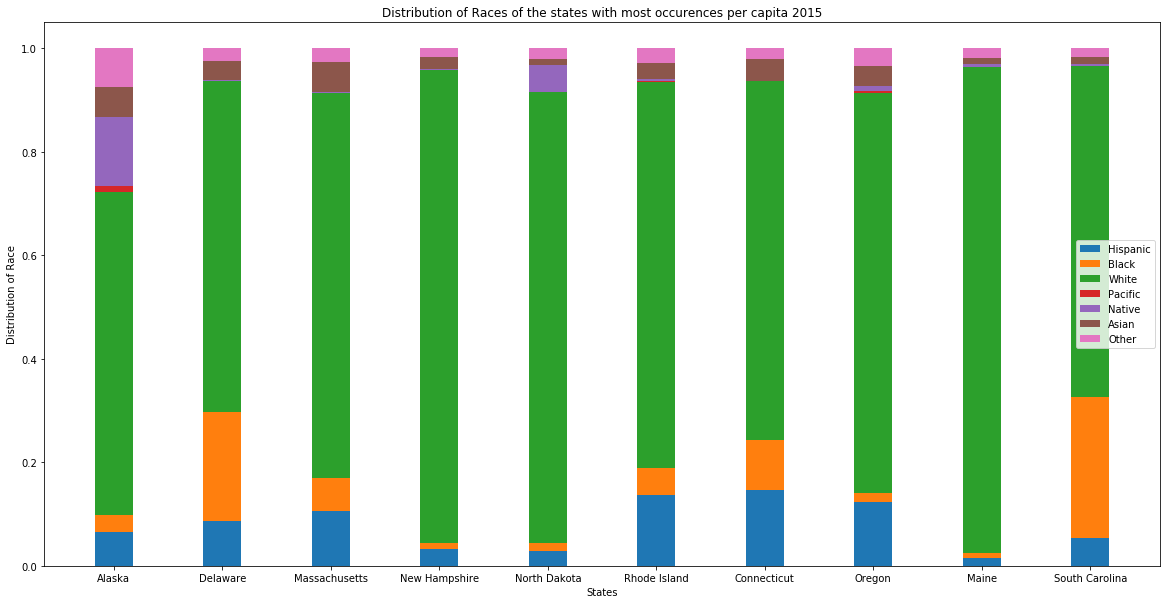

<Figure size 432x288 with 0 Axes>

In [50]:
#Create stacked bar chart for top 10
states = df_incidents_race_2015_top10.iloc[:,0]
barHis = df_incidents_race_2015_top10.iloc[:,2]
barBla = df_incidents_race_2015_top10.iloc[:,3]
barWhi = df_incidents_race_2015_top10.iloc[:,4]
barPac = df_incidents_race_2015_top10.iloc[:,5]
barNat = df_incidents_race_2015_top10.iloc[:,6]
barAsi = df_incidents_race_2015_top10.iloc[:,7]
barOth = df_incidents_race_2015_top10.iloc[:,10]
indx = np.arange(len(df_incidents_race_2015_top10))

plt.figure(figsize = (20,10))

graphH = plt.bar(x=indx, height = barHis,width = 0.35, label="Hispanic")
graphB = plt.bar(x=indx, height = barBla,width = 0.35, bottom = barHis.values , label = "Black")
graphW = plt.bar(x=indx, height = barWhi,width = 0.35, bottom = barHis.values + barBla.values , label = "White")
graphP = plt.bar(x=indx, height = barPac,width = 0.35, bottom = barHis.values + barBla.values + barWhi.values , label = "Pacific")
graphN = plt.bar(x=indx, height = barNat,width = 0.35, bottom = barHis.values + barBla.values + barWhi.values + barPac.values , label = "Native")
graphA = plt.bar(x=indx, height = barAsi,width = 0.35, bottom = barHis.values + barBla.values + barWhi.values + barPac.values + barNat.values , label = "Asian")
graphO = plt.bar(x=indx, height = barOth,width = 0.35, bottom = barHis.values + barBla.values + barWhi.values + barPac.values + barNat.values + barAsi.values, label = "Other")

plt.xlabel('States')
plt.ylabel('Distribution of Race')
plt.xticks(indx,states)
plt.title('Distribution of Races of the states with most occurences per capita 2015')
plt.legend()
plt.show()
plt.savefig("GDistribution of Races of the states with most occurences per capita 2015")

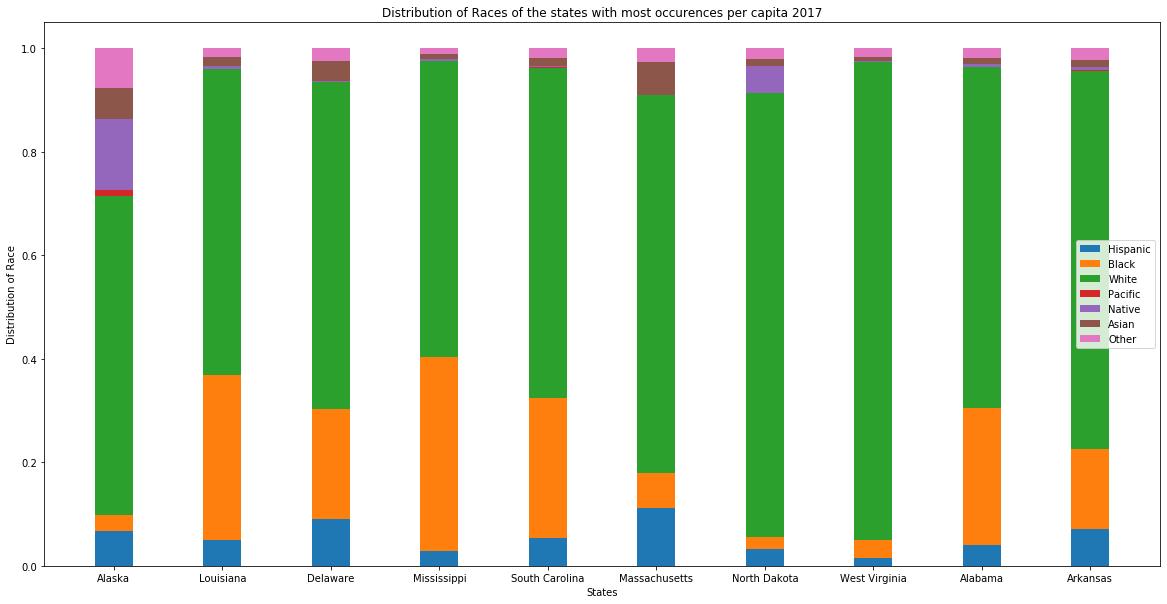

<Figure size 432x288 with 0 Axes>

In [51]:
#Create stacked bar chart for top 10
states = df_incidents_race_2017_top10.iloc[:,0]
barHis = df_incidents_race_2017_top10.iloc[:,2]
barBla = df_incidents_race_2017_top10.iloc[:,3]
barWhi = df_incidents_race_2017_top10.iloc[:,4]
barPac = df_incidents_race_2017_top10.iloc[:,5]
barNat = df_incidents_race_2017_top10.iloc[:,6]
barAsi = df_incidents_race_2017_top10.iloc[:,7]
barOth = df_incidents_race_2017_top10.iloc[:,10]
indx = np.arange(len(df_incidents_race_2017_top10))

plt.figure(figsize = (20,10))

graphH = plt.bar(x=indx, height = barHis,width = 0.35, label="Hispanic")
graphB = plt.bar(x=indx, height = barBla,width = 0.35, bottom = barHis.values , label = "Black")
graphW = plt.bar(x=indx, height = barWhi,width = 0.35, bottom = barHis.values + barBla.values , label = "White")
graphP = plt.bar(x=indx, height = barPac,width = 0.35, bottom = barHis.values + barBla.values + barWhi.values , label = "Pacific")
graphN = plt.bar(x=indx, height = barNat,width = 0.35, bottom = barHis.values + barBla.values + barWhi.values + barPac.values , label = "Native")
graphA = plt.bar(x=indx, height = barAsi,width = 0.35, bottom = barHis.values + barBla.values + barWhi.values + barPac.values + barNat.values , label = "Asian")
graphO = plt.bar(x=indx, height = barOth,width = 0.35, bottom = barHis.values + barBla.values + barWhi.values + barPac.values + barNat.values + barAsi.values, label = "Other")

plt.xlabel('States')
plt.ylabel('Distribution of Race')
plt.xticks(indx,states)
plt.title('Distribution of Races of the states with most occurences per capita 2017')
plt.legend()
plt.show()
plt.savefig("GDistribution of Races of the states with most occurences per capita 2017")

Now that we've observed the top 10, let's look at the bottom 10 for any trends

In [82]:
# Select only bottom 10 based on incidents
df_incidents_race_2015_bot10 = df_incidents_race_2015_clean.sort_values('incidents per capita', ascending = True).head(10)
# Correction for races outside those listed to make distribution of population equal to 100%
df_incidents_race_2015_bot10['Other'] = 1 - df_incidents_race_2015_bot10.Hispanic - df_incidents_race_2015_bot10.Black - df_incidents_race_2015_bot10.White - df_incidents_race_2015_bot10.Pacific - df_incidents_race_2015_bot10.Native - df_incidents_race_2015_bot10.Asian
df_incidents_race_2015_bot10

,State,TotalPop,Hispanic,Black,White,Pacific,Native,Asian,incident_counts_2015,incidents per capita,Other
2,Arizona,6641928,0.303385,0.039600,0.564887,0.001745,0.040025,0.029180,70,0.000011,0.021178
0,Alabama,4830620,0.039993,0.263028,0.663411,0.000227,0.004562,0.012287,58,0.000012,0.016492
45,Virginia,8256630,0.085916,0.189057,0.634387,0.000676,0.002022,0.059214,117,0.000014,0.028729
23,Mississippi,2988081,0.028988,0.372330,0.573765,0.000063,0.004023,0.009590,46,0.000015,0.011242
42,Texas,26538614,0.384151,0.115825,0.438467,0.000737,0.002574,0.041767,420,0.000016,0.016479
4,California,38421464,0.383810,0.056166,0.387250,0.003469,0.003766,0.135151,618,0.000016,0.030388
15,Kansas,2892987,0.111736,0.056612,0.770439,0.000361,0.007078,0.025795,51,0.000018,0.027980
32,North Carolina,9845333,0.088327,0.211772,0.642359,0.000434,0.011017,0.024625,196,0.000020,0.021467
3,Arkansas,2958208,0.068708,0.154364,0.735963,0.002243,0.005601,0.013520,59,0.000020,0.019601
8,Florida,19645772,0.237310,0.154426,0.560596,0.000393,0.002103,0.025438,409,0.000021,0.019735


In [52]:
# Select only bottom 10 based on incidents
df_incidents_race_2017_bot10 = df_incidents_race_2017_clean.sort_values('incidents per capita', ascending = True).head(10)
# Correction for races outside those listed to make distribution of population equal to 100%
df_incidents_race_2017_bot10['Other'] = 1 - df_incidents_race_2017_bot10.Hispanic - df_incidents_race_2017_bot10.Black - df_incidents_race_2017_bot10.White - df_incidents_race_2017_bot10.Pacific - df_incidents_race_2017_bot10.Native - df_incidents_race_2017_bot10.Asian
df_incidents_race_2017_bot10

,State,TotalPop,Hispanic,Black,White,Pacific,Native,Asian,incident_counts_2017,incidents per capita,Other
42,Texas,27419612,0.389301,0.116666,0.428579,0.000787,0.002546,0.044652,995,0.000036,0.017468
2,Arizona,6809946,0.308879,0.040697,0.555882,0.001745,0.038882,0.030600,257,0.000038,0.023315
43,Utah,2993941,0.136720,0.010665,0.790161,0.008798,0.009346,0.022477,115,0.000038,0.021832
31,New York,19798228,0.188199,0.143674,0.559475,0.000052,0.002084,0.082662,835,0.000042,0.023854
22,Minnesota,5490726,0.051914,0.058492,0.807650,0.000108,0.009402,0.046420,239,0.000044,0.026013
4,California,38982847,0.387512,0.055475,0.379096,0.003467,0.003563,0.139294,1699,0.000044,0.031592
21,Michigan,9925568,0.048829,0.136858,0.754933,0.000077,0.004524,0.028938,472,0.000048,0.025841
27,Nevada,2887725,0.282116,0.083980,0.504485,0.006276,0.008491,0.079195,155,0.000054,0.035458
5,Colorado,5436519,0.212872,0.038733,0.686498,0.001513,0.005255,0.029676,302,0.000056,0.025453
48,Wisconsin,5763217,0.066087,0.062440,0.818193,0.000117,0.008106,0.026320,322,0.000056,0.018737


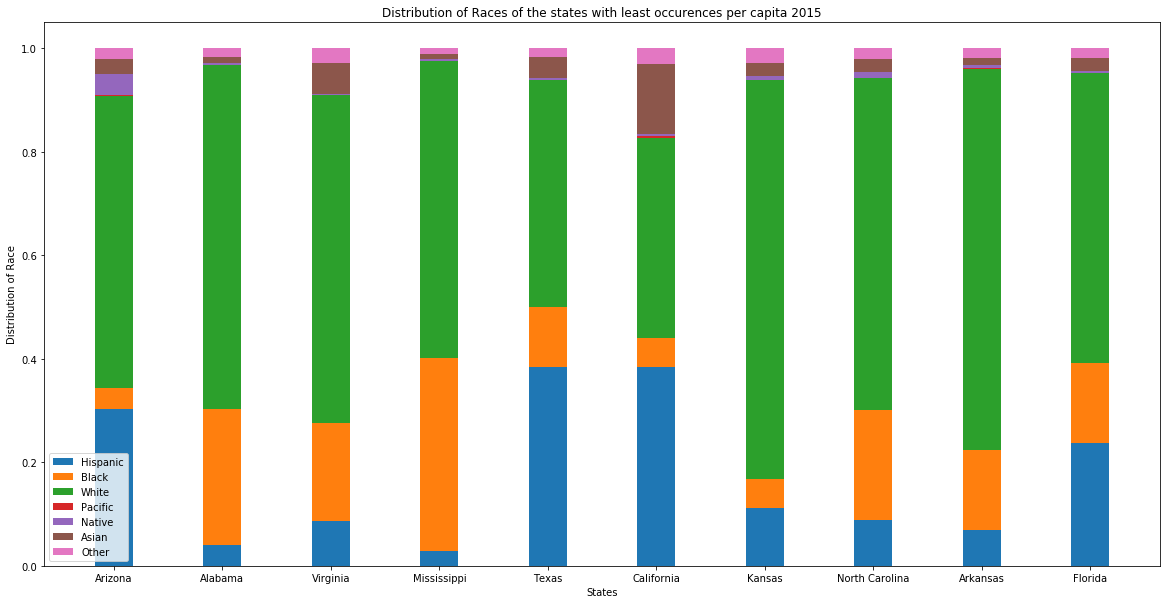

<Figure size 1080x720 with 0 Axes>

In [83]:
#Create stacked bar chart for bottom 10
states = df_incidents_race_2015_bot10.iloc[:,0]
barHis = df_incidents_race_2015_bot10.iloc[:,2]
barBla = df_incidents_race_2015_bot10.iloc[:,3]
barWhi = df_incidents_race_2015_bot10.iloc[:,4]
barPac = df_incidents_race_2015_bot10.iloc[:,5]
barNat = df_incidents_race_2015_bot10.iloc[:,6]
barAsi = df_incidents_race_2015_bot10.iloc[:,7]
barOth = df_incidents_race_2015_bot10.iloc[:,10]
indx = np.arange(len(df_incidents_race_2015_bot10))

plt.figure(figsize = (20,10))

graphH = plt.bar(x=indx, height = barHis,width = 0.35, label="Hispanic")
graphB = plt.bar(x=indx, height = barBla,width = 0.35, bottom = barHis.values , label = "Black")
graphW = plt.bar(x=indx, height = barWhi,width = 0.35, bottom = barHis.values + barBla.values , label = "White")
graphP = plt.bar(x=indx, height = barPac,width = 0.35, bottom = barHis.values + barBla.values + barWhi.values , label = "Pacific")
graphN = plt.bar(x=indx, height = barNat,width = 0.35, bottom = barHis.values + barBla.values + barWhi.values + barPac.values , label = "Native")
graphA = plt.bar(x=indx, height = barAsi,width = 0.35, bottom = barHis.values + barBla.values + barWhi.values + barPac.values + barNat.values , label = "Asian")
graphO = plt.bar(x=indx, height = barOth,width = 0.35, bottom = barHis.values + barBla.values + barWhi.values + barPac.values + barNat.values + barAsi.values, label = "Other")

plt.xlabel('States')
plt.ylabel('Distribution of Race')
plt.xticks(indx,states)
plt.title('Distribution of Races of the states with least occurences per capita 2015')
plt.legend()
plt.show()
plt.savefig("GDistribution of Races of the states with least occurences per capita 2015")

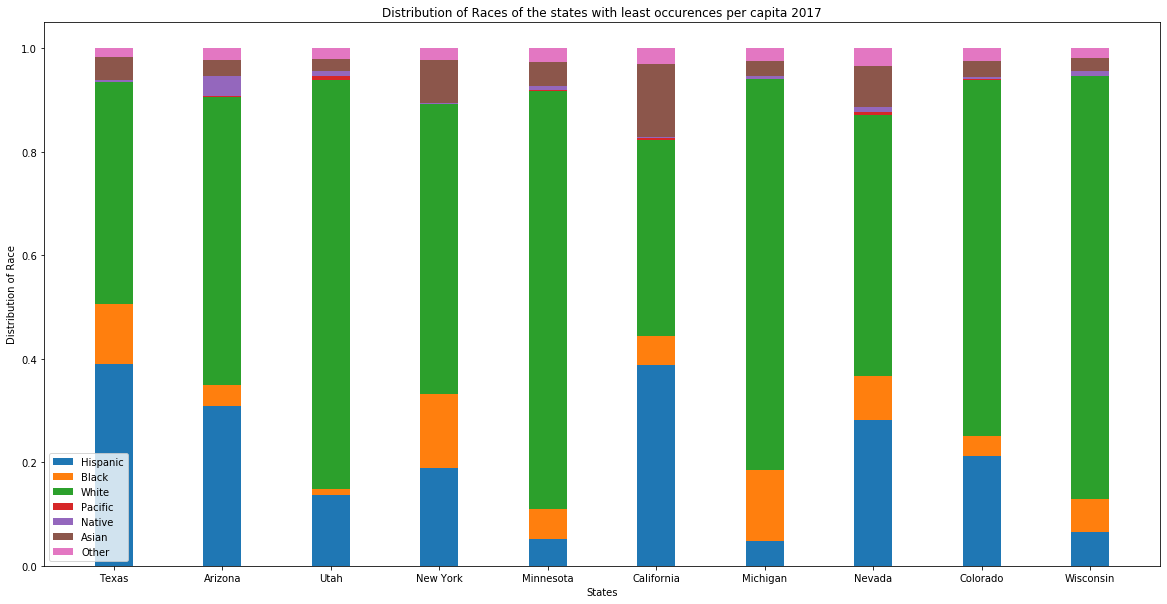

<Figure size 1080x720 with 0 Axes>

In [84]:
#Create stacked bar chart for bottom 10
states = df_incidents_race_2017_bot10.iloc[:,0]
barHis = df_incidents_race_2017_bot10.iloc[:,2]
barBla = df_incidents_race_2017_bot10.iloc[:,3]
barWhi = df_incidents_race_2017_bot10.iloc[:,4]
barPac = df_incidents_race_2017_bot10.iloc[:,5]
barNat = df_incidents_race_2017_bot10.iloc[:,6]
barAsi = df_incidents_race_2017_bot10.iloc[:,7]
barOth = df_incidents_race_2017_bot10.iloc[:,10]
indx = np.arange(len(df_incidents_race_2017_bot10))

plt.figure(figsize = (20,10))

graphH = plt.bar(x=indx, height = barHis,width = 0.35, label="Hispanic")
graphB = plt.bar(x=indx, height = barBla,width = 0.35, bottom = barHis.values , label = "Black")
graphW = plt.bar(x=indx, height = barWhi,width = 0.35, bottom = barHis.values + barBla.values , label = "White")
graphP = plt.bar(x=indx, height = barPac,width = 0.35, bottom = barHis.values + barBla.values + barWhi.values , label = "Pacific")
graphN = plt.bar(x=indx, height = barNat,width = 0.35, bottom = barHis.values + barBla.values + barWhi.values + barPac.values , label = "Native")
graphA = plt.bar(x=indx, height = barAsi,width = 0.35, bottom = barHis.values + barBla.values + barWhi.values + barPac.values + barNat.values , label = "Asian")
graphO = plt.bar(x=indx, height = barOth,width = 0.35, bottom = barHis.values + barBla.values + barWhi.values + barPac.values + barNat.values + barAsi.values, label = "Other")

plt.xlabel('States')
plt.ylabel('Distribution of Race')
plt.xticks(indx,states)
plt.title('Distribution of Races of the states with least occurences per capita 2017')
plt.legend()
plt.show()
plt.savefig("GDistribution of Races of the states with least occurences per capita 2017")

From the stacked bar graphs, there is no significant observable difference between the states' racial distribution. Thus, even though these are the top 10 and bottom 10 in terms of the level of gun incidents there is still no conclusive evidence that links race to gun violence holistically between the states.

# 3. Modelling

### 3.1. Contribution of Race to Incidents per Capita

The goal now is to predict how much weightage each race has to the incidents per capita value. To do this, we can use a simple model - Linear Regression.

This is because the models are taking in continuous values of distribution to predict the incidents per capita and we will use an Regressive Feature Elimination to consider what is the "most" impactful

#### Simple Linear Regression

In [54]:
#Create simple Linear Regression model with distribution of races to predict level of incidents in 2015
X = df_incidents_race_2015_clean[['Hispanic', 'Black', 'White', 'Pacific', 'Native', 'Asian']]
y = df_incidents_race_2015_clean[['incidents per capita']]
X_train, X_test = train_test_split(X, test_size=0.3, random_state=7)
y_train, y_test = train_test_split(y, test_size=0.3, random_state=7)
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
# Obtain MSE and r2 for testing data
y_test_pred = model.predict(X_test)
print("Checking testing values")
print("MSE: ", mean_squared_error(y_test,y_test_pred))
print("R2:" , r2_score(y_test, y_test_pred))

Checking testing values
MSE:  1.1345745321069865e-09
R2: -0.47114682999680846


In [56]:
# Obtain MSE and r2 for training data
y_train_pred = model.predict(X_train)
print("Checking training values")
print("MSE: ", mean_squared_error(y_train,y_train_pred))
print("R2:" , r2_score(y_train, y_train_pred))

Checking training values
MSE:  3.460116196788565e-10
R2: 0.20532728013384427


From the change in the R2 value we can say that the model has been overfitted and that the model is not accurate for 2015 data

In [57]:
#Create simple Linear Regression model with distribution of races to predict level of incidents in 2017
X = df_incidents_race_2017_clean[['Hispanic', 'Black', 'White', 'Pacific', 'Native', 'Asian']]
y = df_incidents_race_2017_clean[['incidents per capita']]
X_train, X_test = train_test_split(X, test_size=0.3, random_state=7)
y_train, y_test = train_test_split(y, test_size=0.3, random_state=7)
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
# Obtain MSE and r2 for testing data
y_test_pred = model.predict(X_test)
print("Checking testing values")
print("MSE: ", mean_squared_error(y_test,y_test_pred))
print("R2:" , r2_score(y_test, y_test_pred))

Checking testing values
MSE:  1.6052175390906673e-09
R2: -0.16625757944711816


In [59]:
# Obtain MSE and r2 for training data
y_train_pred = model.predict(X_train)
print("Checking training values")
print("MSE: ", mean_squared_error(y_train,y_train_pred))
print("R2:" , r2_score(y_train, y_train_pred))

Checking training values
MSE:  4.766859255277321e-10
R2: 0.47132621760282034


As expected, similar results show that the model is overfitting but is still not accurate. This means that the race variables as inputs are not able to properly predict the level of gun occurences per state and could mean that gun violence as a whole is not affected by the race in a state but we understand the individual cases of gun violence may be affected by the victim or suspects race.

#### RFE (Linear Regression of Race)

With Recursive Feature Estimation (RFE), we are trying to find the best features for our model by eliminating the least useful features one by one. 

First we need to train our model with all features and look at the coefficients to determine which feature is the least useful. Once the feature is removed, we will run the training again on the smaller set of features until we have our target number of features in our model.

In [60]:
feature_cols = np.array(['Hispanic', 'Black', 'White', 'Pacific', 'Native', 'Asian'])

for i in range(1,7):
    
    estimator = LinearRegression()
    selector = RFE(estimator, i)
    selector = selector.fit(X, y)

    supp = selector.get_support()
    print("Testing ", i, " Selected features:", feature_cols[supp])
    print("Coeffs:", selector.estimator_.coef_)
    # test the model
    predicted = selector.predict(X)
    
    print("MSE:", mean_squared_error(y, predicted))
    print("R^2:", r2_score(y, predicted))
    print('')

Testing  1  Selected features: ['Pacific']
Coeffs: [0.00156287]
MSE: 1.068089066360067e-09
R^2: 0.012271268026484483

Testing  2  Selected features: ['Pacific' 'Native']
Coeffs: [-0.00085641  0.00047965]
MSE: 9.248864722290611e-10
R^2: 0.14469965922644956

Testing  3  Selected features: ['Black' 'Pacific' 'Native']
Coeffs: [0.00016044 0.00022146 0.00062385]
MSE: 7.282453848044121e-10
R^2: 0.32654596591859664

Testing  4  Selected features: ['Hispanic' 'Black' 'Pacific' 'Native']
Coeffs: [-0.00013226  0.00014546  0.00107006  0.0006277 ]
MSE: 5.506983798145039e-10
R^2: 0.4907347809038616

Testing  5  Selected features: ['Hispanic' 'Black' 'Pacific' 'Native' 'Asian']
Coeffs: [-1.23548919e-04  1.47573694e-04  1.40589985e-03  6.06867656e-04
 -7.52202747e-05]
MSE: 5.482546301145758e-10
R^2: 0.4929946690240504

Testing  6  Selected features: ['Hispanic' 'Black' 'White' 'Pacific' 'Native' 'Asian']
Coeffs: [-1.45011073e-04  1.25390705e-04 -2.21677199e-05  1.34698440e-03
  5.80005202e-04 -1.0148

Based on the RFE results and the Linear Regression Model, although MSE is an extremely low value close to 0, we should not take the values of MSE as accurate due to the magnitude of the "incidents per capita". A better estimator of the accuracy of the model is the R2 value and since the highest R2 value is when all 6 races are combined, we cannot conclude any absolute significance of a particular race to the level of occurence in the states from our model.

### 3.2. Modelling Severity to Daily Weather Data

We are looking into time-specific datasets such as weather that can provide us with unique value to each incident. We want to further look at whether these underlying variables might be able to help predict the severity of a gun violence incident.

In [61]:
# This is a function that maps daily weather values to the time and location of the incident.
def clean_join(main, source, col):
    joint_data = pd.merge(main, source, on='date', how='left')
    
    cleaned_df = []
    maincols = main['state']
    for x in range(0, len(joint_data.date)):
        for y in source.columns:
            if joint_data['state'][x] == y:
                cleaned_df.append(joint_data[y][x])
    
    cleaned_df = pd.DataFrame(cleaned_df)
    cleaned_df.columns = col
    joint_data = pd.concat([joint_data, cleaned_df], axis = 1)
    joint_data = joint_data.drop(temp.columns, axis = 1)
    
    return joint_data

In [62]:
# Applying the function above to the gun violence data
gun_violence_weather_analysis = clean_join(gun_violence_data_clean, temp, ['Temperature'])
gun_violence_weather_analysis = clean_join(gun_violence_weather_analysis, humid, ['Humidity'])
gun_violence_weather_analysis = clean_join(gun_violence_weather_analysis, pressure, ['Pressure'])
gun_violence_weather_analysis = clean_join(gun_violence_weather_analysis, wind, ['Wind Speed'])

In [63]:
# We are defining severity based on the definition stated within our dataset and Douglas, Burgess, Burgess, and Ressler, Crime Classification Manual, 2006
def severity(nk, ni):
    if nk == 0:
        if ni > 0:
            return 'People Wounded'
        return 'Shots Fired'
    
    if nk > 3:
        return 'Mass Shooting'
    return 'Homicide'

In [64]:
# Applying Classification funtion into df
gun_violence_weather_analysis['severity'] = gun_violence_weather_analysis.apply(lambda x: severity(x.n_killed, x.n_injured), axis=1)

In [65]:
# Dropping null values
gun_violence_weather_analysis_clean = gun_violence_weather_analysis.dropna()

In [66]:
# Final datasets being used in the model
gun_violence_weather_analysis_clean.head()

,incident_id,date,state,n_killed,n_injured,latitude,longitude,n_guns_involved,year,month,suspect_age,suspect_gender,day_of_week,Temperature,Humidity,Pressure,Wind Speed,severity
0,478855,2013-01-01,Ohio,1,3,41.4455,-82.1377,2.0,2013,1,25,0,1,280.119583,60.666667,1022.166667,1.333333,Homicide
1,478959,2013-01-07,North Carolina,2,2,36.1140,-79.9569,2.0,2013,1,47,1,0,273.420833,49.750000,1028.476190,1.000000,Homicide
2,479363,2013-01-19,New Mexico,5,0,34.9791,-106.7160,2.0,2013,1,15,0,5,268.904167,56.777778,1014.777778,3.583333,Mass Shooting
3,479561,2013-01-26,Louisiana,2,3,29.8816,-91.5251,1.0,2013,1,48,0,5,286.312552,58.175000,1020.352273,1.333333,Homicide
4,479573,2013-02-02,Tennessee,0,5,35.0803,-89.8871,1.0,2013,2,24,1,5,285.070885,56.400000,1016.423913,2.822917,People Wounded


In [67]:
# Calculating Pearson's Correlation for each pair of variables
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = round(corr_r, 2)
    ax = plt.gca()
    font_size = 30
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

In [68]:
# Data used for the pair plot
pair_data = gun_violence_weather_analysis_clean[['severity', 'n_killed', 'n_injured', 'n_guns_involved', 'month',
                                                 'suspect_age', 'suspect_gender', 'day_of_week', 'Temperature',
                                                 'Humidity', 'Pressure', 'Wind Speed']]

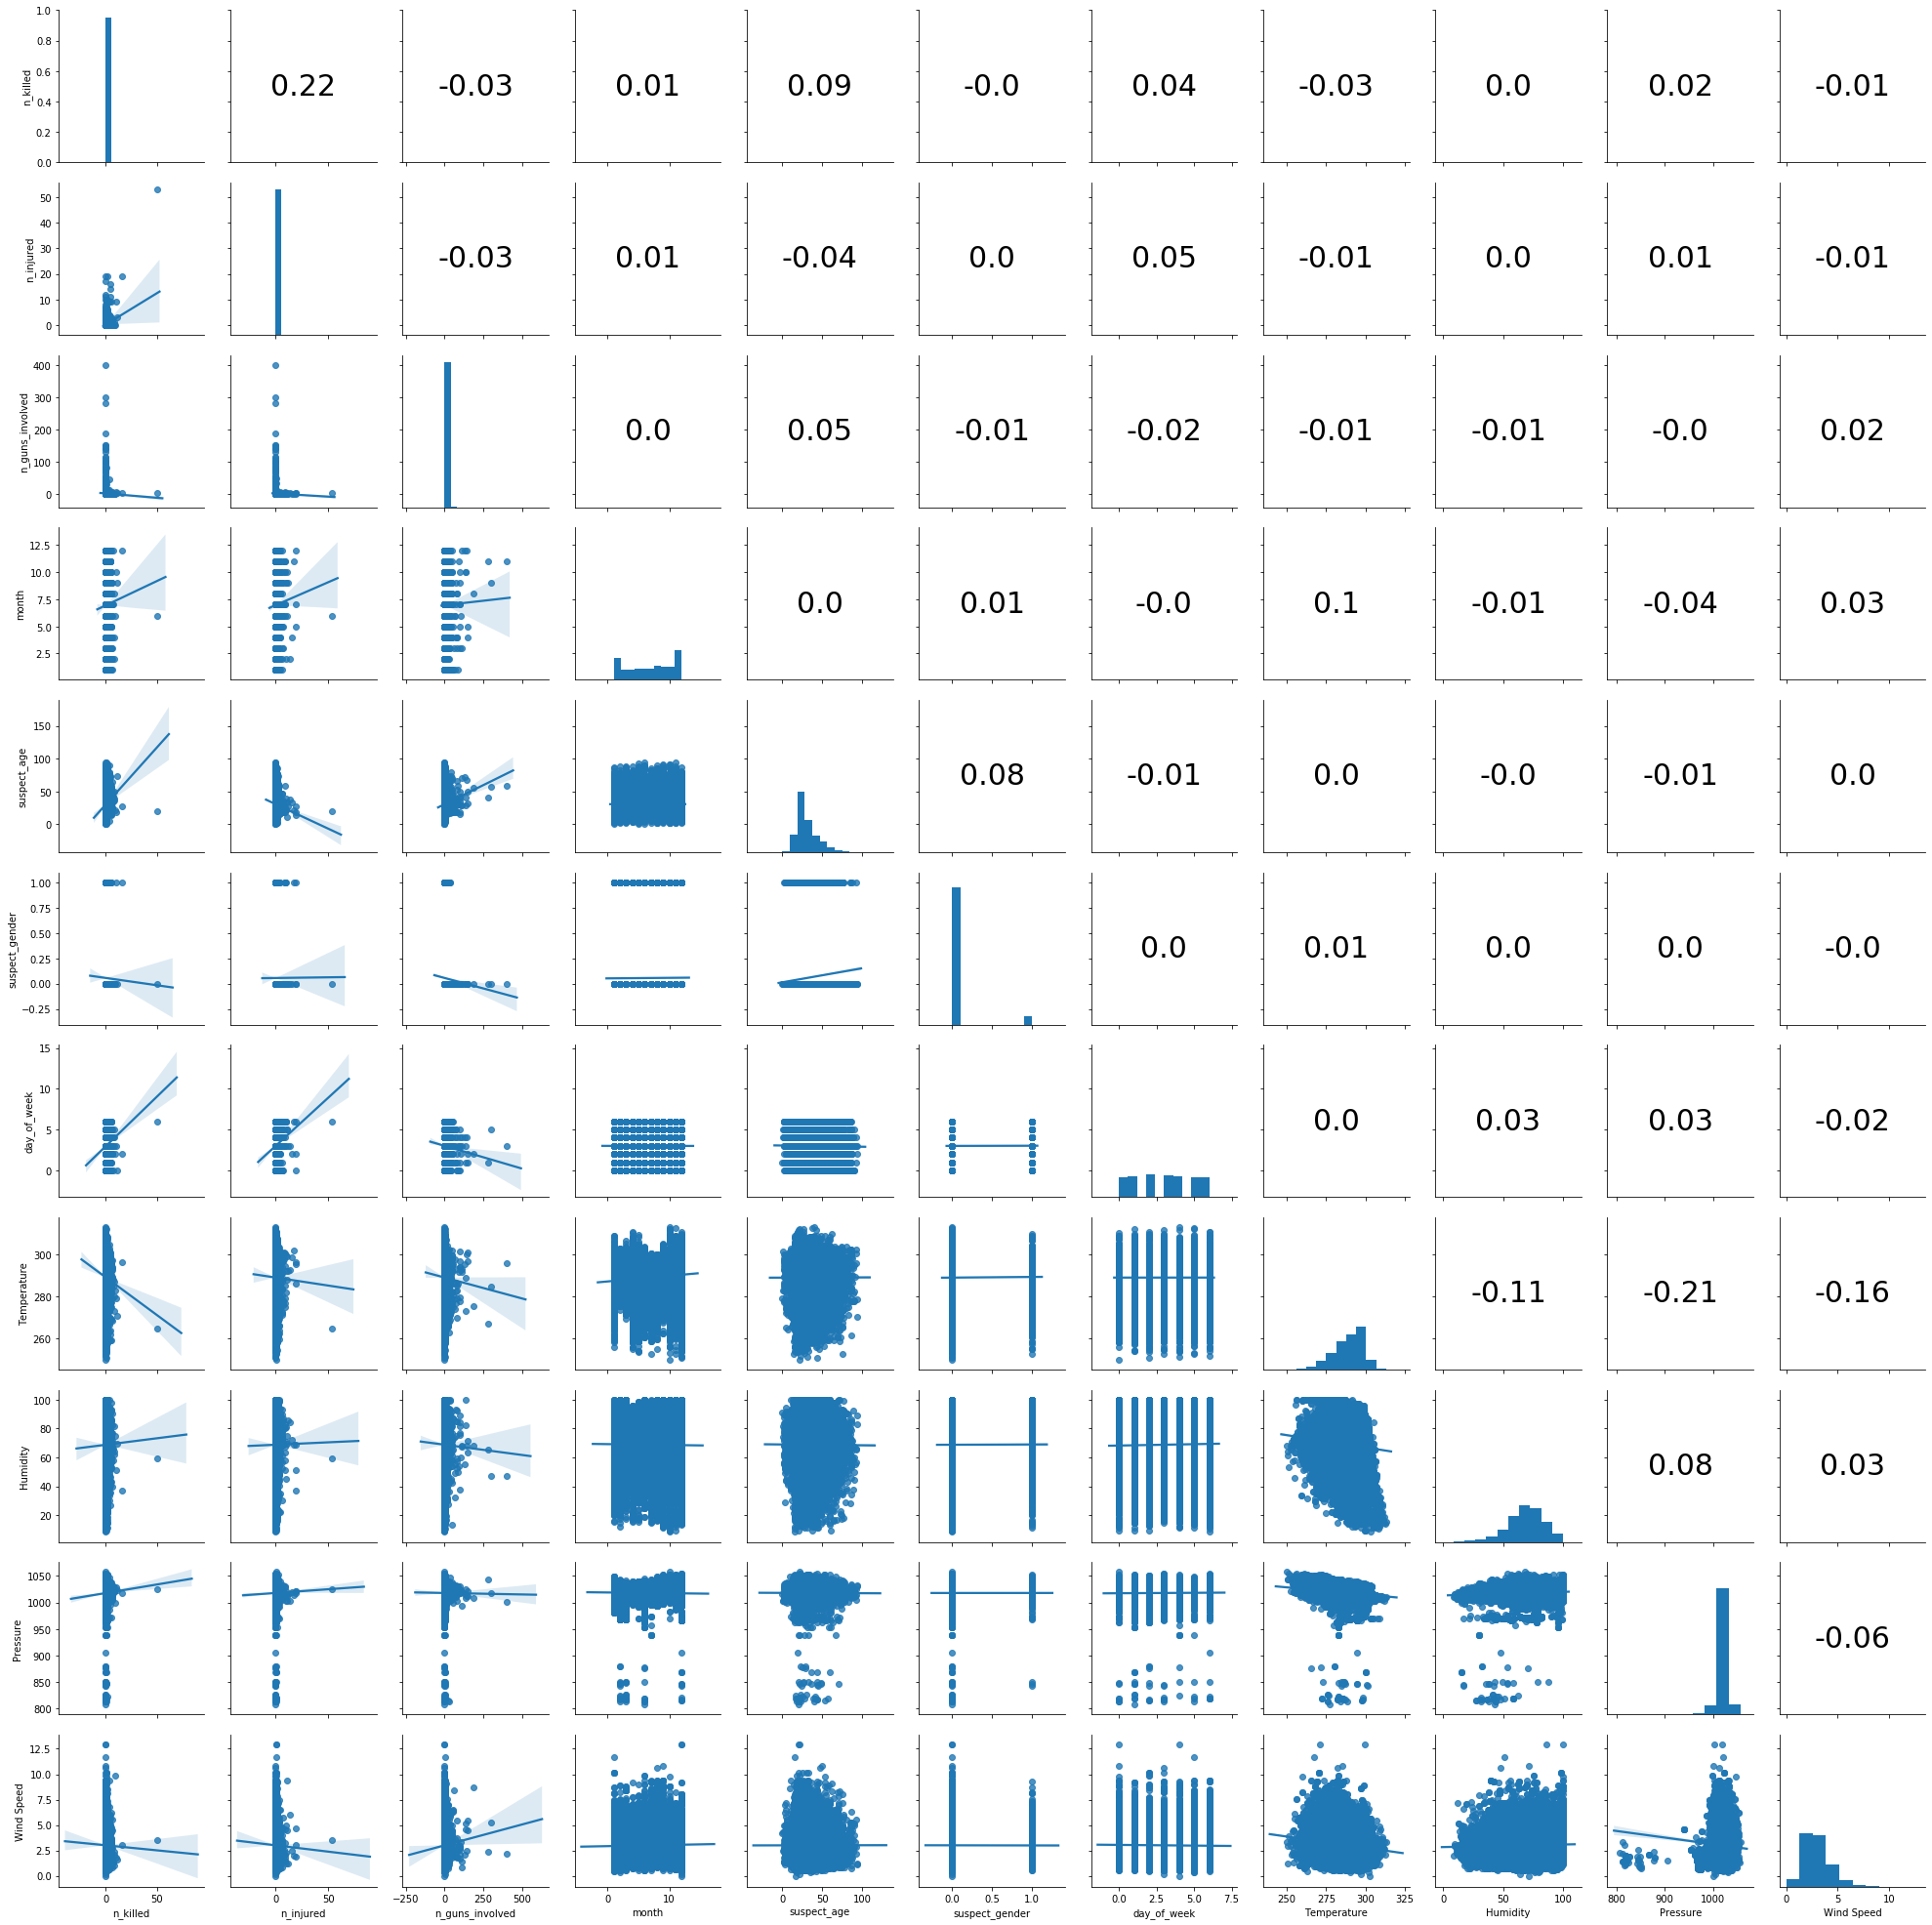

In [69]:
# Pair plot
pairplot = sns.PairGrid(gun_violence_weather_analysis_clean, vars=['n_killed', 'n_injured', 'n_guns_involved', 'month',
                                                 'suspect_age', 'suspect_gender', 'day_of_week', 'Temperature',
                                                 'Humidity', 'Pressure', 'Wind Speed'])
pairplot.map_upper(corrdot)
pairplot.map_lower(sns.regplot)
pairplot.map_diag(plt.hist)

After this, we are looking at different models to see how accurately they can predict the severity of our dataset.
Specifically, we are looking at **Logictic Regression**, **Decision Tree Classifier**, and **Neural Networks**.

In [70]:
# Splitting the training and testing data
#X = gun_violence_weather_analysis_clean[['n_killed', 'n_injured', 'Temperature', 'Humidity', 
                                                      #'Pressure', 'Wind Speed']]
X = gun_violence_weather_analysis_clean[['Temperature', 'Humidity', 'n_guns_involved', 'month', 'suspect_age',
                                         'suspect_gender', 'day_of_week', 'Pressure', 'Wind Speed']]
y = gun_violence_weather_analysis_clean[['severity']]
       
X_train, X_test = train_test_split(X, test_size=0.3, random_state=7)
y_train, y_test = train_test_split(y, test_size=0.3, random_state=7)

#### Logistic Regression

In [71]:
# Testing a Logistic Regression model with different number of features
model = LogisticRegression()

for i in range(1,10):
    rfe = RFE(estimator=model, n_features_to_select=i, step=1)
    rfe.fit(X_train, y_train)

    y_pred = rfe.predict(X_test)
    print("Test accuracy",i,":", accuracy_score(y_test, y_pred))
    print("Confusion matrix",i)
    print(confusion_matrix(y_test, y_pred))
    print()

Test accuracy 1 : 0.579966926529648
Confusion matrix 1
[[   0    0    0 1967]
 [   0    0    0   27]
 [   0    0    0 1562]
 [   0    0    0 4910]]

Test accuracy 2 : 0.579966926529648
Confusion matrix 2
[[   0    0    0 1967]
 [   0    0    0   27]
 [   0    0    0 1562]
 [   0    0    0 4910]]

Test accuracy 3 : 0.579966926529648
Confusion matrix 3
[[   0    0    0 1967]
 [   0    0    0   27]
 [   0    0    0 1562]
 [   0    0    0 4910]]

Test accuracy 4 : 0.579966926529648
Confusion matrix 4
[[   0    0    0 1967]
 [   0    0    0   27]
 [   0    0    0 1562]
 [   0    0    0 4910]]

Test accuracy 5 : 0.579966926529648
Confusion matrix 5
[[   0    0    0 1967]
 [   0    0    0   27]
 [   0    0    0 1562]
 [   0    0    0 4910]]

Test accuracy 6 : 0.5800850460666194
Confusion matrix 6
[[   1    0    0 1966]
 [   0    0    0   27]
 [   1    0    0 1561]
 [   0    0    0 4910]]

Test accuracy 7 : 0.5802031656035909
Confusion matrix 7
[[   2    0    0 1965]
 [   0    0    0   27]
 [ 

#### Decision Tree Classifier

In [72]:
# Testing a Decision Tree Classifier model with different number of features
model = DecisionTreeClassifier(random_state=0, max_depth = 6)

for i in range(1,10):
    rfe = RFE(estimator=model, n_features_to_select=i, step=1)
    rfe.fit(X_train, y_train)

    y_pred = rfe.predict(X_test)
    print("Test accuracy",i,":", accuracy_score(y_test, y_pred))
    print("Confusion matrix",i)
    print(confusion_matrix(y_test, y_pred))
    print()

Test accuracy 1 : 0.579966926529648
Confusion matrix 1
[[   0    0    0 1967]
 [   0    0    0   27]
 [   0    0    0 1562]
 [   0    0    0 4910]]

Test accuracy 2 : 0.5797306874557052
Confusion matrix 2
[[  19    0    7 1941]
 [   0    0    1   26]
 [  15    0   13 1534]
 [  18    0   16 4876]]

Test accuracy 3 : 0.5766595794944483
Confusion matrix 3
[[  36    0    7 1924]
 [   1    0    0   26]
 [  35    0   13 1514]
 [  65    0   12 4833]]

Test accuracy 4 : 0.5774864162532483
Confusion matrix 4
[[  87    0    7 1873]
 [   2    0    0   25]
 [  44    0   17 1501]
 [ 109    0   16 4785]]

Test accuracy 5 : 0.5783132530120482
Confusion matrix 5
[[  81    0    9 1877]
 [   2    0    0   25]
 [  45    0   22 1495]
 [  95    0   22 4793]]

Test accuracy 6 : 0.5784313725490197
Confusion matrix 6
[[  86    0   15 1866]
 [   3    0    0   24]
 [  48    0   24 1490]
 [ 101    0   22 4787]]

Test accuracy 7 : 0.5778407748641625
Confusion matrix 7
[[  90    0   15 1862]
 [   3    0    0   24]

#### Neural Network

In [73]:
# Testing a Decision Tree Classifier model with different number of hidden layers
AS_train = []
AS_test = []

for x in range(1,10):
    mlp = MLPClassifier(hidden_layer_sizes=10*x, random_state=0)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    print("Test accuracy",x,":", accuracy_score(y_test, y_pred))
    print("Confusion matrix",i)
    print(confusion_matrix(y_test, y_pred))
    print()

Test accuracy 1 : 0.579966926529648
Confusion matrix 9
[[   0    0    0 1967]
 [   0    0    0   27]
 [   0    0    0 1562]
 [   0    0    0 4910]]

Test accuracy 2 : 0.3134892511221356
Confusion matrix 9
[[1842    0    0  125]
 [  22    0    0    5]
 [1432    0    0  130]
 [4097    0    1  812]]

Test accuracy 3 : 0.5794944483817623
Confusion matrix 9
[[   0    0    0 1967]
 [   0    0    0   27]
 [   0    0    0 1562]
 [   2    0    2 4906]]

Test accuracy 4 : 0.5798488069926766
Confusion matrix 9
[[   0    0    0 1967]
 [   0    0    0   27]
 [   0    0    0 1562]
 [   0    1    0 4909]]

Test accuracy 5 : 0.5800850460666194
Confusion matrix 9
[[   1    0    0 1966]
 [   0    0    0   27]
 [   1    0    0 1561]
 [   0    0    0 4910]]

Test accuracy 6 : 0.579966926529648
Confusion matrix 9
[[   0    0    0 1967]
 [   0    0    0   27]
 [   0    0    0 1562]
 [   0    0    0 4910]]

Test accuracy 7 : 0.579966926529648
Confusion matrix 9
[[   0    0    0 1967]
 [   0    0    0   27]
 

These models used are not able to accurately predict the level of severity for each incident, regardless of the number of variables fitted through python.

Although we cann see improvements in the model such as in Logistic Regression when we use at least 6 variables, this is not enough to create an accurate model.

From this, we can conclude that the severity of gun occurences cannot be predicted according to the variables listed in the dataset.

### 3.3. Identifying Locations most prone to Gun Violence

We want to look at areas in the Unites states most occurences of gun violence and allow us to see which areas have more gun violence occurences.

After plotting, we are usuing KMeans Clustering to find 20 cluster points that we can have an approximate "concentration point" of where these incidents occur.

In this analysis, we will be dropping incidents outside the main island of the US so we will not consider Hawaii and Alaska for the sake of simplicity. We have extracted the image of the United States from Google Maps and used coordinated to pin point the exact coordinates we are superimposing onto the scatterplot.

In [74]:
# Dropping Alaska and Hawaii
location_analysis_data = gun_violence_data_clean[gun_violence_data_clean['state']!='Alaska']
location_analysis_data = location_analysis_data[location_analysis_data['state']!='Hawaii']

In [75]:
# Final Dataset used for 
location_analysis_data.head()

,incident_id,date,state,n_killed,n_injured,latitude,longitude,n_guns_involved,year,month,suspect_age,suspect_gender,day_of_week
2,478855,2013-01-01,Ohio,1,3,41.4455,-82.1377,2.0,2013,1,25,0,1
4,478959,2013-01-07,North Carolina,2,2,36.1140,-79.9569,2.0,2013,1,47,1,0
6,479363,2013-01-19,New Mexico,5,0,34.9791,-106.7160,2.0,2013,1,15,0,5
12,479561,2013-01-26,Louisiana,2,3,29.8816,-91.5251,1.0,2013,1,48,0,5
15,479573,2013-02-02,Tennessee,0,5,35.0803,-89.8871,1.0,2013,2,24,1,5


Now we will use K Nearest Neighbour to determine where are the central areas with the highest occurence of gun violence

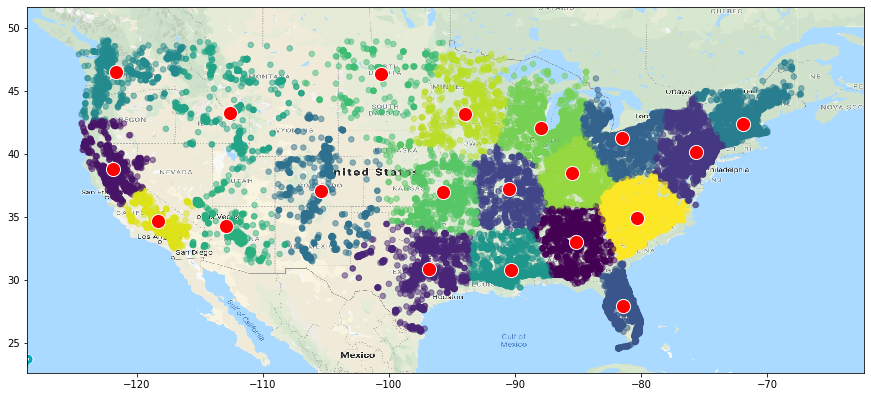

In [80]:
km_data = location_analysis_data[['longitude', 'latitude']]
kmeans = KMeans(n_clusters=20).fit(km_data)
centroids = kmeans.cluster_centers_

map = imread('data/USmap.png')
#plt.rcParams["figure.figsize"] = [2.5 * i for i in plt.rcParams["figure.figsize"]]
plt.imshow(map, extent = [-128.742,-62.297,22.606,51.660])
plt.xlim(-128.742,-62.297)
plt.ylim(22.606,51.660)
plt.scatter(km_data['longitude'], km_data['latitude'], c= kmeans.labels_.astype(float), s=30, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, edgecolor='w')
plt.savefig("Heatmap")

From the map, we can observe that California has 2 cluster points within the state around San Francisco and Los Angeles and the state with the least is Nevada. We have also identified a community of clusters indicating a high level of gun violence.

## 4. Qualitative Analysis

From our analysis, we found out that:

1. Considering our results with the socio-economic data, due to the difference in how GDP and homelessness has changed over 2014 to 2016 as compared to the number of casualties, we can conclude that the number of casualties are not affected by these socio-economic factors. This could be because the data is looking at the US holistically and is not seperated by state. 

    There are intricacies between the social economic status (SES) between states due to the different regulatory bodies and we are only considering one small portion as a representation of the US SES data. Hence, the results may not be accurate but this is expected due to how many factors are aggregated with the overall data.
    

2. With demographic data, there is not enough of a significance to link any specific race to gun violence. **The previous analysis done had also used demographic data but did not split it into race. We can conclude that having the race data per state may have decreased the accuracy of their model as it does not seem to be a good variable to predict data.**

    We understand that although this is our conclusion from the Data Analysis, there is a definite impact on race towards the level of gun deaths in the US and that our study does not take into account the complex factors that go into combining race, discrimination and subconscious bias during a shooting.


3. Our efforts to make a predictive model with the weather and suspect characteristic variables shows that the highest accuracy we can obtain by utilising the weather data is less than 60% and is not significant enough to be used as a predictor. We hereby conclude that the underlying factors tested (temperature, wind speed, pressure, humidity, suspect gender, suspect age, number of guns involved, day of week, and month) are not strong enough to predict the severity of gun violence occurences.


4. The scatter-map produced provides a high-level view of where the incidents happen. With the help of clustering, we are able to pinpoint "cluster-points" to see where there is a higher concentration of occurences. We concluded that there is a higher number of incidents around the ourside borders of the United States, and less so in the inside.

## 5. Conclusion

Our hypothesis was to prove that **gun Violence has a missing factor that we are not considering** through the of **finding an underlying factor that contributes to gun violence in the US** and **predicting the severity of gun violence in the US**.

What we've concluded overall is that **the factors considered in this analysis does not impact gun violence**. Furthermore, albeit having some relation to gun violence, the variables we have tested in this report are **unable to acccurately predict severity and occurence accurately.**